### importing modules

In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 15

In [2]:
import numpy as np
import gym
from collections import deque
import random
import pickle

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# from tensorflow.python.keras.layers import Dense
# from tensorflow.python.keras import Sequential
# from tensorflow.python.keras.optimizers import Adam

Using TensorFlow backend.


### some constants and variables

In [4]:
# variables

discount = 0.9
epsilon = 0.1
memory_cap = 999999999
# n_step = 4

### classes for different methods

In [240]:
class Q_Learning_Default:
    
    def __init__(self, o_space, a_space, buffer, lr, n_step):
        self.n_step = n_step
        self.a_space = a_space
        self.buffer = buffer
        self.lr = lr
        self.experience = deque(maxlen=memory_cap)
        
        self.clf = Sequential()
        self.clf.add(Dense(64, input_shape=(o_space,), activation="relu"))
        self.clf.add(Dense(64, activation="relu"))
        self.clf.add(Dense(self.a_space, activation="linear"))
        self.clf.compile(loss="mse", optimizer=Adam(lr=lr))
        
        self.reset_multistep_exp()
        
    def add_experience(self, s, a, r, s_next, terminal):
        self.multistep_step += 1
        self.multistep_rewards.append(r)
        
        if self.multistep_step == 1:
            self.multistep_state = s
            self.multistep_action = a
        
        if self.multistep_step == self.n_step:
            reward = 0
            
            for i in range(len(self.multistep_rewards)):
                step_reward = self.multistep_rewards[i]
                reward += (discount ** i) * step_reward
                
            self.experience.append([self.multistep_state, self.multistep_action, reward, s_next, terminal])
            self.reset_multistep_exp()
        
    def reset_multistep_exp(self):
        self.multistep_step = 0
        self.multistep_state = None
        self.multistep_action = None
        self.multistep_rewards = []
        
    def get_action(self, s):
        random_explore = np.random.rand()
        
        if random_explore < epsilon:
            return random.randrange(self.a_space)
        
        q_vals = self.clf.predict(s)
        
        return np.argmax(q_vals[0])
    
    def experience_replay(self):
        if len(self.experience) < self.buffer:
            return
        
        exp_batch = random.sample(self.experience, self.buffer)
        
        for s, a, r, s_next, terminal in exp_batch:
            q_update = r
            
            print("s_next", s_next)
            print("s_next shape", s_next.shape)
            
            if not terminal:
                q_update = (r + discount * np.amax(self.clf.predict(s_next)[0]))
            
            q_vals = self.clf.predict(s)
            q_vals[0][a] = q_update
            self.clf.fit(s, q_vals, verbose=0)


In [27]:
class Q_Learning_HER:
    
    def __init__(self, o_space, a_space, buffer, lr, n_step):
        self.n_step = n_step
        self.a_space = a_space
        self.buffer = buffer
        self.lr = lr
        self.experience = []#deque(maxlen=memory_cap)
        self.her_experience = []#deque(maxlen=memory_cap)
        
        self.clf = Sequential()
        self.clf.add(Dense(64, input_shape=(o_space,), activation="relu"))
        self.clf.add(Dense(64, activation="relu"))
        self.clf.add(Dense(self.a_space, activation="linear"))
        self.clf.compile(loss="mse", optimizer=Adam(lr=lr))
        
    def add_experience(self, s, a, r, s_next, terminal):
        self.experience.append([s, a, r, s, terminal])
        
    def add_her_experience(self, s, a, r, s_next, terminal):
        self.her_experience.append([s, a, r, s, terminal])
        
    def get_action(self, s):
        random_explore = np.random.rand()
        
        if random_explore < epsilon:
            return random.randrange(self.a_space)
        
        q_vals = self.clf.predict(s)
        
        return np.argmax(q_vals[0])
    
    def experience_replay(self):
        min_buffer_len = np.min([len(self.experience), self.buffer])
        
        exp_batch = random.sample(self.experience, min_buffer_len)
        
        for s, a, r, s_next, terminal in exp_batch:
            q_update = r
            
            if not terminal:
                q_update = (r + discount * np.amax(self.clf.predict(s_next)[0]))
            
            q_vals = self.clf.predict(s)
            q_vals[0][a] = q_update
            self.clf.fit(s, q_vals, verbose=0)
            
    def modify_her_list(self):
        new_her_experience = copy.deepcopy(self.her_experience)
        new_her_len = len(new_her_experience)
        her_goal = self.her_experience[-1][3]
        
        for i in range(new_her_len):
            new_her_experience[-1-i][0] = her_goal
            new_her_experience[-1-i][2] = -1.0
            new_her_experience[-1-i][3] = her_goal
            new_her_experience[-1-i][4] = False
            
            if (np.sum(np.abs((new_her_experience[-1-i][4] - her_goal))) == 0):
                new_her_experience[-1-i][2] = 0.0
                new_her_experience[-1-i][4] = True
        
        for hx in new_her_experience:
            self.experience.append(hx)
            
    def reset_her(self):
        self.her_experience = [] # deque(maxlen=memory_cap)


In [28]:
class Q_Learning_HERQ:
    
    def __init__(self, o_space, a_space, buffer, lr, n_step):
        self.n_step = n_step
        self.a_space = a_space
        self.buffer = buffer
        self.lr = lr
        self.experience = deque(maxlen=memory_cap)
        self.her_experience = deque(maxlen=memory_cap)
        
        self.clf = Sequential()
        self.clf.add(Dense(64, input_shape=(o_space,), activation="relu"))
        self.clf.add(Dense(64, activation="relu"))
        self.clf.add(Dense(self.a_space, activation="linear"))
        self.clf.compile(loss="mse", optimizer=Adam(lr=lr))
        
    def add_experience(self, s, a, r, s_next, terminal):
        self.experience.append([s, a, r, s, terminal])
        
    def add_her_experience(self, s, a, r, s_next, terminal):
        self.her_experience.append([s, a, r, s, terminal])
        
    def get_action(self, s):
        random_explore = np.random.rand()
        
        if random_explore < epsilon:
            return random.randrange(self.a_space)
        
        q_vals = self.clf.predict(s)
        
        return np.argmax(q_vals[0])
    
    def experience_replay(self):
        min_buffer_len = np.min([len(self.experience), self.buffer])
        
        exp_batch = random.sample(self.experience, min_buffer_len)
        
        for s, a, r, s_next, terminal in exp_batch:
            q_update = r
            
            if not terminal:
                q_update = (r + discount * np.amax(self.clf.predict(s_next)[0]))
            
            q_vals = self.clf.predict(s)
            q_vals[0][a] = q_update
            self.clf.fit(s, q_vals, verbose=0)
            
    def modify_her_list(self):
        new_her_experience = copy.deepcopy(self.her_experience)
        new_her_len = len(new_her_experience)
        her_goal = self.her_experience[-1][3]
        
        for i in range(new_her_len):
            new_her_experience[-1-i][0] = her_goal
            new_her_experience[-1-i][2] = -1.0
            new_her_experience[-1-i][3] = her_goal
            new_her_experience[-1-i][4] = False
            
            if (np.sum(np.abs((new_her_experience[-1-i][4] - her_goal))) == 0):
                new_her_experience[-1-i][2] = 0.0
                new_her_experience[-1-i][4] = True
        
        for hx in new_her_experience:
            self.experience.append(hx)
            
    def reset_her(self):
        self.her_experience = deque(maxlen=memory_cap)


In [ ]:
import time

In [283]:
class Q_Learning_Simple:
    
    def __init__(self, o_space, a_space, buffer, lr, n_step, state_shape):
        self.n_step = n_step
        self.a_space = a_space
        self.buffer = buffer
        self.lr = lr
        
        self.memory_cap = memory_cap
        self.st_idx = 0
        self.memory_size = 0
        
        print(state_shape)
        
        state_list_shape = [self.memory_cap] + list(state_shape)
        
        self.s = np.zeros(state_list_shape, dtype=float)
        self.a = np.zeros(memory_cap, dtype=int)
        self.r = np.zeros(memory_cap, dtype=float)
        self.s_next = np.zeros(state_list_shape, dtype=float)
        self.terminal = np.zeros(memory_cap, dtype=bool)
        
        print(self.s)
        print(self.a)
        print(self.r)
        print(self.s_next)
        print(self.terminal)
                
        self.clf = Sequential()
        self.clf.add(Dense(64, input_shape=state_shape, activation="relu"))
        self.clf.add(Dense(64, activation="relu"))
        self.clf.add(Dense(self.a_space, activation="linear"))
        self.clf.compile(loss="mse", optimizer=Adam(lr=lr))
        
    def add_experience(self, s, a, r, s_next, terminal):
        self.s[self.st_idx] = s
        self.a[self.st_idx] = a
        self.r[self.st_idx] = r
        self.s_next[self.st_idx] = s_next
        self.terminal[self.st_idx] = terminal
        
        if self.memory_size < self.memory_cap:
            self.memory_size += 1
            
        self.st_idx += 1
        
        if self.st_idx >= self.memory_cap:
            self.st_idx = 0 # resetting at 0
        
    def get_action(self, s):
        random_explore = np.random.rand()
        
        if random_explore < epsilon:
            return random.randrange(self.a_space)
        
        q_vals = self.clf.predict(s)
        
        return np.argmax(q_vals[0])
    
    def experience_replay(self):
        
#         print(self.experience)
#         exp_np = np.array(self.experience)
#         print(type(exp_np))
#         print(exp_np)
        
        time_a = time.time()
        min_buffer_len = np.min([self.memory_size, self.buffer])
#         print("min buffer", min_buffer_len)
        time_b = time.time()
#         exp_batch = random.sample(exp_np, min_buffer_len)
#         print(exp_batch)
#         print(0, len(self.experience), min_buffer_len)
        idx = np.random.randint(low=0, high=self.memory_size, size=min_buffer_len, dtype=int)
#         print(idx)
#         print(exp_np)
        s_batch = self.s[idx]
        a_batch = self.a[idx]
        r_batch = self.r[idx]
        s_next_batch = self.s_next[idx]
        terminal_batch = self.terminal[idx]
        
        time_c = time.time()
        
#         print("s_batch 1 shape", s_batch)

        for i in range(len(s_batch)):
            s = np.array([s_batch[i]])
            a = a_batch[i]
            r = r_batch[i]
            s_next = np.array([s_next_batch[i]])
            terminal = terminal_batch[i]
            
#             print(s)
#             print(s_next)
        
            q_update = r
            
#             s_next
            
#             print("s_next", s_next)
#             print("s_next shape", s_next.shape)
            
            if not terminal:
                q_update = (r + discount * np.amax(self.clf.predict(s_next)[0]))
            
            q_vals = self.clf.predict(s)
            q_vals[0][a] = q_update
#             print(type(q_vals))
#             print(type(s))
            self.clf.fit(s, q_vals, verbose=0)
            
        time_d = time.time()
        
        a_perc = (time_b - time_a) / (time_d - time_a)
        b_perc = (time_c - time_b) / (time_d - time_a)
        c_perc = (time_d - time_c) / (time_d - time_a)
#         d_perc = (time_e - time_d) / (time_e - time_a)

#         print("a", a_perc*100)
#         print("b", b_perc*100)
#         print("c", c_perc*100)
#         print("d", d_perc*100)


### main

In [284]:
# learning_rates = [0.5, 0.1, 0.01, 0.001, 0.0001]
# buffers = [50, 100, 250, 500]
# methods = ['sarsa', 'exp_sarsa', 'q']
# seeds = np.arange(20)

# max_episodes = 100

# more doable (recommended by Veronica)

learning_rates = [0.1, 0.01, 0.001]
buffers = [50, 100, 250, 500]
methods = ['sarsa', 'exp_sarsa', 'q']
seeds = np.arange(5)
max_episodes = 100

# learning_rates = [0.1, 0.01, 0.001]
# learning_rates = [0.1, 0.01]
# buffers = [50]
# methods = ['exp_sarsa']
# seeds = np.arange(1)

# max_episodes = 25

n_step = 1

In [285]:
buffer = 50
lr = 0.01
seed = 0
n_step = 1


max_episodes = 100

In [287]:
print(buffer, lr, seed)
np.random.seed(seed)

eps_steps = []
env = gym.make('CartPole-v1')
o_space = env.observation_space.shape[0]
a_space = env.action_space.n

clf = Q_Learning_Simple(o_space, a_space, buffer, lr, n_step, env.observation_space.shape)

num_episode = 0

for num_episode in range(1, max_episodes+1):# while True:
    start = time.time()
    s = env.reset()
    s = np.reshape(s, [1, o_space])

    num_step = 0
    while True:
        num_step += 1
        
        time_a = time.time()
        a = clf.get_action(s)
        
        time_b = time.time()
        s_next, r, terminal, _ = env.step(a)
        s_next = np.reshape(s_next, [1, o_space])

        if terminal:
            r = -r
        else:
            r = r
        
        time_c = time.time()
        clf.add_experience(s, a, r, s_next, terminal)

        s = s_next

        if terminal:
            print("num_episode: {num_episode}; terminal_step: {num_step}".format(num_episode=num_episode, num_step=num_step))
            eps_steps.append(num_step)
            break
        
        time_d = time.time()
        clf.experience_replay()
        
        time_e = time.time()
        
#         a_perc = (time_b - time_a) / (time_e - time_a)
#         b_perc = (time_c - time_b) / (time_e - time_a)
#         c_perc = (time_d - time_c) / (time_e - time_a)
#         d_perc = (time_e - time_d) / (time_e - time_a)

#         print("a", a_perc*100)
#         print("b", b_perc*100)
#         print("c", c_perc*100)
#         print("d", d_perc*100)
        
    end = time.time()
    elapsed = end - start
    
    print("elapsed", elapsed)

50 0.01 0
(4,)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 ...
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 ...
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[False False False ... False False False]
num_episode: 1; terminal_step: 9
elapsed 2.426754951477051
num_episode: 2; terminal_step: 11
elapsed 0.4008049964904785
num_episode: 3; terminal_step: 9
elapsed 0.5666489601135254
num_episode: 4; terminal_step: 12
elapsed 1.0456719398498535
num_episode: 5; terminal_step: 17
elapsed 2.071460247039795
num_episode: 6; terminal_step: 11
elapsed 1.3390552997589111
num_episode: 7; terminal_step: 13
elapsed 1.6791038513183594
num_episode: 8; terminal_step: 14
elapsed 1.8453609943389893
num_episode: 9; terminal_step: 20
elapsed 2.6963162422180176
num_episode: 10; terminal_step: 10
elapsed 1.2614240646362305
num_episode: 11; terminal_step: 13
elapsed 1.6731247901916504
num_episode: 12; terminal_step: 33
elaps

KeyboardInterrupt: 

In [ ]:
print(buffer, lr, seed)
np.random.seed(seed)

eps_steps = []
env = gym.make('CartPole-v1')
o_space = env.observation_space.shape[0]
a_space = env.action_space.n

clf = Q_Learning_HER(o_space, a_space, buffer, lr, n_step)

num_episode = 0

for num_episode in range(1, max_episodes+1):# while True:
    start = time.time()
    s = env.reset()
    s = np.reshape(s, [1, o_space])
    clf.reset_her()

    num_step = 0
    while True:
        num_step += 1

        a = clf.get_action(s)

        s_next, r, terminal, _ = env.step(a)
        s_next = np.reshape(s_next, [1, o_space])

        if terminal:
            r = -r
        else:
            r = r
        
        clf.add_experience(s, a, r, s_next, terminal)
        clf.add_her_experience(s, a, r, s_next, terminal)

        s = s_next

        if terminal:
            print("num_episode: {num_episode}; terminal_step: {num_step}".format(num_episode=num_episode, num_step=num_step))
            eps_steps.append(num_step)
            break

        clf.experience_replay()
    end = time.time()
    elapsed = end - start
    print(elapsed)

In [ ]:
print(buffer, lr, seed)
np.random.seed(seed)

eps_steps = []
env = gym.make('CartPole-v1')
o_space = env.observation_space.shape[0]
a_space = env.action_space.n

clf = Q_Learning_HERQ(o_space, a_space, buffer, lr, n_step)

num_episode = 0

for num_episode in range(1, max_episodes+1):# while True:
    start = time.time()
    s = env.reset()
    s = np.reshape(s, [1, o_space])
    clf.reset_her()

    num_step = 0
    while True:
        num_step += 1

        a = clf.get_action(s)

        s_next, r, terminal, _ = env.step(a)
        s_next = np.reshape(s_next, [1, o_space])

        if terminal:
            r = -r
        else:
            r = r
        
        clf.add_experience(s, a, r, s_next, terminal)
        clf.add_her_experience(s, a, r, s_next, terminal)

        s = s_next

        if terminal:
            print("num_episode: {num_episode}; terminal_step: {num_step}".format(num_episode=num_episode, num_step=num_step))
            eps_steps.append(num_step)
            break

        clf.experience_replay()
    end = time.time()
    elapsed = end - start
    print(elapsed)

In [26]:
print(buffer, lr, seed)
np.random.seed(seed)

eps_steps = []
env = gym.make('CartPole-v1')
o_space = env.observation_space.shape[0]
a_space = env.action_space.n

clf = Q_Learning_HER(o_space, a_space, buffer, lr, n_step)

num_episode = 0

for num_episode in range(1, max_episodes+1):# while True:
    start = time.time()
    s = env.reset()
    s = np.reshape(s, [1, o_space])
    clf.reset_her()

    num_step = 0
    while True:
        num_step += 1

        a = clf.get_action(s)

        s_next, r, terminal, _ = env.step(a)
        s_next = np.reshape(s_next, [1, o_space])

        if terminal:
            r = -r
        else:
            r = r
        
        clf.add_experience(s, a, r, s_next, terminal)
        clf.add_her_experience(s, a, r, s_next, terminal)

        s = s_next

        if terminal:
            print("num_episode: {num_episode}; terminal_step: {num_step}".format(num_episode=num_episode, num_step=num_step))
            eps_steps.append(num_step)
            break

        clf.experience_replay()
    end = time.time()
    elapsed = end - start
    print(elapsed)

50 0.01 0
num_episode: 1; terminal_step: 10
0.907524824142456
num_episode: 2; terminal_step: 15
0.5968668460845947
num_episode: 3; terminal_step: 14
0.8050639629364014
num_episode: 4; terminal_step: 9
0.6469621658325195
num_episode: 5; terminal_step: 11
0.9324600696563721
num_episode: 6; terminal_step: 17
1.466541051864624
num_episode: 7; terminal_step: 8
0.6855208873748779
num_episode: 8; terminal_step: 34
3.120595932006836
num_episode: 9; terminal_step: 9
0.7865400314331055
num_episode: 10; terminal_step: 17
1.616866111755371


KeyboardInterrupt: 

In [9]:
print(buffer, lr, seed)
np.random.seed(seed)

eps_steps = []
env = gym.make('CartPole-v1')
o_space = env.observation_space.shape[0]
a_space = env.action_space.n

clf = Q_Learning_HER(o_space, a_space, buffer, lr, n_step)

num_episode = 0

for num_episode in range(1, max_episodes+1):# while True:
    s = env.reset()
    s = np.reshape(s, [1, o_space])
    clf.reset_her()

    num_step = 0
    while True:
        num_step += 1

        a = clf.get_action(s)

        s_next, r, terminal, _ = env.step(a)
        s_next = np.reshape(s_next, [1, o_space])

        if terminal:
            r = -r
        else:
            r = r
        
        clf.add_experience(s, a, r, s_next, terminal)
        clf.add_her_experience(s, a, r, s_next, terminal)

        s = s_next

        if terminal:
            print("num_episode: {num_episode}; terminal_step: {num_step}".format(num_episode=num_episode, num_step=num_step))
            eps_steps.append(num_step)
            break

        clf.experience_replay()

50 0.01 0
num_episode: 1; terminal_step: 10
num_episode: 2; terminal_step: 10
num_episode: 3; terminal_step: 15
num_episode: 4; terminal_step: 20
num_episode: 5; terminal_step: 26
num_episode: 6; terminal_step: 62
num_episode: 7; terminal_step: 14
num_episode: 8; terminal_step: 27
num_episode: 9; terminal_step: 26
num_episode: 10; terminal_step: 26
num_episode: 11; terminal_step: 13
num_episode: 12; terminal_step: 13
num_episode: 13; terminal_step: 39
num_episode: 14; terminal_step: 25
num_episode: 15; terminal_step: 16
num_episode: 16; terminal_step: 36
num_episode: 17; terminal_step: 21
num_episode: 18; terminal_step: 11
num_episode: 19; terminal_step: 23
num_episode: 20; terminal_step: 45
num_episode: 21; terminal_step: 48
num_episode: 22; terminal_step: 50
num_episode: 23; terminal_step: 13
num_episode: 24; terminal_step: 28
num_episode: 25; terminal_step: 21
num_episode: 26; terminal_step: 11
num_episode: 27; terminal_step: 9
num_episode: 28; terminal_step: 60
num_episode: 29; ter

In [10]:
eps_steps

[10,
 10,
 15,
 20,
 26,
 62,
 14,
 27,
 26,
 26,
 13,
 13,
 39,
 25,
 16,
 36,
 21,
 11,
 23,
 45,
 48,
 50,
 13,
 28,
 21,
 11,
 9,
 60,
 38,
 16,
 19,
 13,
 12,
 17,
 16,
 17,
 13,
 25,
 33,
 27,
 13,
 19,
 48,
 21,
 23,
 39,
 15,
 20,
 15,
 21,
 38,
 54,
 12,
 42,
 12,
 21,
 22,
 12,
 25,
 18,
 16,
 18,
 21,
 8,
 32,
 22,
 20,
 14,
 10,
 30,
 18,
 27,
 10,
 12,
 38,
 20,
 12,
 22,
 16,
 13,
 15,
 13,
 22,
 51,
 24,
 20,
 20,
 16,
 17,
 13,
 28,
 11,
 15,
 12,
 18,
 30,
 21,
 63,
 18,
 18]

In [241]:
print(buffer, lr, seed)
np.random.seed(seed)

eps_steps = []
env = gym.make('CartPole-v1')
o_space = env.observation_space.shape[0]
a_space = env.action_space.n

clf = Q_Learning_Default(o_space, a_space, buffer, lr, n_step)

num_episode = 0

for num_episode in range(1, max_episodes+1):# while True:
    s = env.reset()
    s = np.reshape(s, [1, o_space])
#     clf.reset_her()

    num_step = 0
    while True:
        num_step += 1

        a = clf.get_action(s)

        s_next, r, terminal, _ = env.step(a)
        s_next = np.reshape(s_next, [1, o_space])

        if terminal:
            r = -r
        else:
            r = r
        
        clf.add_experience(s, a, r, s_next, terminal)
#         clf.add_her_experience(s, a, r, s_next, terminal)

        s = s_next

        if terminal:
            print("num_episode: {num_episode}; terminal_step: {num_step}".format(num_episode=num_episode, num_step=num_step))
            eps_steps.append(num_step)
            break

        clf.experience_replay()

50 0.01 0
num_episode: 1; terminal_step: 38
s_next [[-0.07078047  0.01029027 -0.08434745 -0.42136805]]
s_next shape (1, 4)
s_next [[ 0.05316916  0.04197548 -0.00696011  0.02227207]]
s_next shape (1, 4)
s_next [[0.03641687 0.04225091 0.00810324 0.01619616]]
s_next shape (1, 4)
s_next [[-0.08639219 -0.16588833 -0.18438652 -0.55404453]]
s_next shape (1, 4)
s_next [[-0.05978644 -0.18993004 -0.06683047 -0.01488047]]
s_next shape (1, 4)
s_next [[-0.10008447 -0.35254525 -0.21540157 -0.44913561]]
s_next shape (1, 4)
s_next [[-0.08692352  0.02656668 -0.16860053 -0.78929964]]
s_next shape (1, 4)
s_next [[-0.04003691  0.18930941 -0.04727239 -0.35780851]]
s_next shape (1, 4)
s_next [[-0.0672238   0.00807517 -0.07482758 -0.37208786]]
s_next shape (1, 4)
s_next [[-0.0742455   0.01277768 -0.09590326 -0.47687185]]
s_next shape (1, 4)
s_next [[-0.03990802 -0.00644421 -0.04625443 -0.05089818]]
s_next shape (1, 4)
s_next [[-0.05224423  0.00101176 -0.05342344 -0.21560668]]
s_next shape (1, 4)
s_next [[-0.

s_next [[ 0.05400867  0.23719655 -0.00651467 -0.2725987 ]]
s_next shape (1, 4)
s_next [[-0.08085214  0.01878519 -0.12623017 -0.61184299]]
s_next shape (1, 4)
s_next [[-0.04436924 -0.00201409 -0.05123596 -0.14875658]]
s_next shape (1, 4)
s_next [[-0.05978644 -0.18993004 -0.06683047 -0.01488047]]
s_next shape (1, 4)
s_next [[0.03641687 0.04225091 0.00810324 0.01619616]]
s_next shape (1, 4)
s_next [[ 0.0587526   0.04216816 -0.01196665  0.01802238]]
s_next shape (1, 4)
s_next [[-0.0670623  -0.18590842 -0.08226934 -0.10390549]]
s_next shape (1, 4)
s_next [[ 0.06434516  0.43274525 -0.01717444 -0.5747328 ]]
s_next shape (1, 4)
s_next [[ 0.05959596  0.23745967 -0.0116062  -0.27841201]]
s_next shape (1, 4)
s_next [[-0.05603828 -0.19167803 -0.06155179  0.02375825]]
s_next shape (1, 4)
s_next [[-0.03990802 -0.00644421 -0.04625443 -0.05089818]]
s_next shape (1, 4)
s_next [[-0.04351848 -0.0075687  -0.03911681 -0.02605882]]
s_next shape (1, 4)
s_next [[-0.04833685 -0.00051137 -0.05166444 -0.18194868

s_next [[ 0.0587526   0.04216816 -0.01196665  0.01802238]]
s_next shape (1, 4)
s_next [[-0.03635291 -0.1994109  -0.05603653  0.19462756]]
s_next shape (1, 4)
s_next [[-0.05224423  0.00101176 -0.05342344 -0.21560668]]
s_next shape (1, 4)
s_next [[-0.04351848 -0.0075687  -0.03911681 -0.02605882]]
s_next shape (1, 4)
s_next [[-0.08351533 -0.17040981 -0.15958312 -0.45087065]]
s_next shape (1, 4)
s_next [[-0.10008447 -0.35254525 -0.21540157 -0.44913561]]
s_next shape (1, 4)
s_next [[-0.08639219 -0.16588833 -0.18438652 -0.55404453]]
s_next shape (1, 4)
s_next [[-0.05987184  0.00427015 -0.06107663 -0.28769222]]
s_next shape (1, 4)
s_next [[-0.04440952 -0.19636633 -0.05421109  0.12733244]]
s_next shape (1, 4)
s_next [[-0.03990802 -0.00644421 -0.04625443 -0.05089818]]
s_next shape (1, 4)
s_next [[ 0.04842766  0.23707511 -0.00156176 -0.26991786]]
s_next shape (1, 4)
s_next [[0.03081273 0.04264106 0.01356708 0.00758977]]
s_next shape (1, 4)
s_next [[0.03641687 0.04225091 0.00810324 0.01619616]]
s

s_next [[-0.08396379  0.02242299 -0.14569568 -0.69437215]]
s_next shape (1, 4)
s_next [[-0.0670623  -0.18590842 -0.08226934 -0.10390549]]
s_next shape (1, 4)
s_next [[-0.05609014  0.00259284 -0.05654043 -0.25056837]]
s_next shape (1, 4)
s_next [[-0.04440952 -0.19636633 -0.05421109  0.12733244]]
s_next shape (1, 4)
s_next [[-0.08085214  0.01878519 -0.12623017 -0.61184299]]
s_next shape (1, 4)
s_next [[-0.03625072 -0.00510973 -0.05442856 -0.0803985 ]]
s_next shape (1, 4)
s_next [[-0.04366986  0.18809175 -0.03963798 -0.33082239]]
s_next shape (1, 4)
s_next [[ 0.02605205  0.23803405  0.01938998 -0.29114491]]
s_next shape (1, 4)
s_next [[ 0.03166555  0.23756584  0.01371888 -0.28078189]]
s_next shape (1, 4)
s_next [[ 0.14672393  1.41127606 -0.13512747 -2.11650287]]
s_next shape (1, 4)
s_next [[-0.04034113 -0.00353401 -0.05214398 -0.11519271]]
s_next shape (1, 4)
s_next [[-0.08692352  0.02656668 -0.16860053 -0.78929964]]
s_next shape (1, 4)
s_next [[-0.08639219 -0.16588833 -0.18438652 -0.5540

s_next [[-0.0742455   0.01277768 -0.09590326 -0.47687185]]
s_next shape (1, 4)
s_next [[ 0.05316916  0.04197548 -0.00696011  0.02227207]]
s_next shape (1, 4)
s_next [[-0.03990802 -0.00644421 -0.04625443 -0.05089818]]
s_next shape (1, 4)
s_next [[ 0.17494945  1.60746315 -0.17745753 -2.44770758]]
s_next shape (1, 4)
s_next [[-0.04003691  0.18930941 -0.04727239 -0.35780851]]
s_next shape (1, 4)
s_next [[-0.07760732  0.01559031 -0.10975848 -0.53988346]]
s_next shape (1, 4)
s_next [[-0.03625072 -0.00510973 -0.05442856 -0.0803985 ]]
s_next shape (1, 4)
s_next [[-0.08396379  0.02242299 -0.14569568 -0.69437215]]
s_next shape (1, 4)
s_next [[-0.05224423  0.00101176 -0.05342344 -0.21560668]]
s_next shape (1, 4)
s_next [[-0.08692352  0.02656668 -0.16860053 -0.78929964]]
s_next shape (1, 4)
s_next [[ 0.04758917  0.04192411 -0.00202985  0.02340482]]
s_next shape (1, 4)
s_next [[-0.04034113 -0.00353401 -0.05214398 -0.11519271]]
s_next shape (1, 4)
s_next [[-0.05978644 -0.18993004 -0.06683047 -0.0148

s_next [[-0.0672238   0.00807517 -0.07482758 -0.37208786]]
s_next shape (1, 4)
s_next [[ 0.12242008  1.21519242 -0.09923352 -1.79469759]]
s_next shape (1, 4)
s_next [[-0.08351533 -0.17040981 -0.15958312 -0.45087065]]
s_next shape (1, 4)
s_next [[-0.05603828 -0.19167803 -0.06155179  0.02375825]]
s_next shape (1, 4)
s_next [[-0.07057466 -0.18354168 -0.09277481 -0.15642254]]
s_next shape (1, 4)
s_next [[ 0.03726189  0.23725572  0.00842716 -0.27391913]]
s_next shape (1, 4)
s_next [[-0.04041181 -0.19787154 -0.05444784  0.16059399]]
s_next shape (1, 4)
s_next [[-0.04366986  0.18809175 -0.03963798 -0.33082239]]
s_next shape (1, 4)
s_next [[-0.0672238   0.00807517 -0.07482758 -0.37208786]]
s_next shape (1, 4)
s_next [[-0.08396379  0.02242299 -0.14569568 -0.69437215]]
s_next shape (1, 4)
s_next [[0.03081273 0.04264106 0.01356708 0.00758977]]
s_next shape (1, 4)
s_next [[-0.10008447 -0.35254525 -0.21540157 -0.44913561]]
s_next shape (1, 4)
s_next [[-0.04003691  0.18930941 -0.04727239 -0.35780851

s_next [[-0.05978644 -0.18993004 -0.06683047 -0.01488047]]
s_next shape (1, 4)
s_next [[-0.07057466 -0.18354168 -0.09277481 -0.15642254]]
s_next shape (1, 4)
s_next [[-0.02614537  0.39259656  0.02395401 -0.58994124]]
s_next shape (1, 4)
s_next [[ 0.14672393  1.41127606 -0.13512747 -2.11650287]]
s_next shape (1, 4)
s_next [[ 0.12242008  1.21519242 -0.09923352 -1.79469759]]
s_next shape (1, 4)
s_next [[-0.04834708 -0.19485744 -0.05530341  0.09399886]]
s_next shape (1, 4)
s_next [[-0.0672238   0.00807517 -0.07482758 -0.37208786]]
s_next shape (1, 4)
s_next [[-0.08639219 -0.16588833 -0.18438652 -0.55404453]]
s_next shape (1, 4)
s_next [[-0.05603828 -0.19167803 -0.06155179  0.02375825]]
s_next shape (1, 4)
s_next [[ 0.02605205  0.23803405  0.01938998 -0.29114491]]
s_next shape (1, 4)
s_next [[-0.08692352  0.02656668 -0.16860053 -0.78929964]]
s_next shape (1, 4)
s_next [[-0.06346337 -0.18802172 -0.07368564 -0.05709672]]
s_next shape (1, 4)
s_next [[ 0.00910065  0.97752081 -0.02862089 -1.4581

s_next [[ 0.11077777  1.76066676 -0.18216568 -2.72043804]]
s_next shape (1, 4)
s_next [[ 0.03726189  0.23725572  0.00842716 -0.27391913]]
s_next shape (1, 4)
s_next [[-0.04003691  0.18930941 -0.04727239 -0.35780851]]
s_next shape (1, 4)
s_next [[-0.08047644 -0.17436758 -0.13846703 -0.36143224]]
s_next shape (1, 4)
s_next [[ 0.07948488  1.56464462 -0.1343723  -2.38966867]]
s_next shape (1, 4)
s_next [[-0.08351533 -0.17040981 -0.15958312 -0.45087065]]
s_next shape (1, 4)
s_next [[ 0.05211071  1.36870852 -0.09297754 -2.06973794]]
s_next shape (1, 4)
s_next [[ 0.00910065  0.97752081 -0.02862089 -1.45817393]]
s_next shape (1, 4)
s_next [[-0.05609014  0.00259284 -0.05654043 -0.25056837]]
s_next shape (1, 4)
s_next [[-0.04366986  0.18809175 -0.03963798 -0.33082239]]
s_next shape (1, 4)
s_next [[-0.03635291 -0.1994109  -0.05603653  0.19462756]]
s_next shape (1, 4)
s_next [[ 0.05316916  0.04197548 -0.00696011  0.02227207]]
s_next shape (1, 4)
s_next [[-0.07729551 -0.17783149 -0.12055615 -0.2837

s_next [[-0.08396379  0.02242299 -0.14569568 -0.69437215]]
s_next shape (1, 4)
s_next [[-0.07729551 -0.17783149 -0.12055615 -0.28370085]]
s_next shape (1, 4)
s_next [[-0.04834708 -0.19485744 -0.05530341  0.09399886]]
s_next shape (1, 4)
s_next [[ 0.05400867  0.23719655 -0.00651467 -0.2725987 ]]
s_next shape (1, 4)
s_next [[-0.05222399 -0.19330735 -0.05773557  0.05975713]]
s_next shape (1, 4)
s_next [[-0.05987184  0.00427015 -0.06107663 -0.28769222]]
s_next shape (1, 4)
s_next [[-0.01775563  0.41951217  0.01431795 -0.53861982]]
s_next shape (1, 4)
s_next [[-0.03010369  0.19791604  0.03009198 -0.30689837]]
s_next shape (1, 4)
s_next [[ 0.05211071  1.36870852 -0.09297754 -2.06973794]]
s_next shape (1, 4)
s_next [[-0.04351848 -0.0075687  -0.03911681 -0.02605882]]
s_next shape (1, 4)
s_next [[-0.08047644 -0.17436758 -0.13846703 -0.36143224]]
s_next shape (1, 4)
s_next [[ 0.04758917  0.04192411 -0.00202985  0.02340482]]
s_next shape (1, 4)
s_next [[-0.07398994 -0.18086862 -0.10544069 -0.2158

s_next [[ 0.03166555  0.23756584  0.01371888 -0.28078189]]
s_next shape (1, 4)
s_next [[-0.08396379  0.02242299 -0.14569568 -0.69437215]]
s_next shape (1, 4)
s_next [[-0.04834708 -0.19485744 -0.05530341  0.09399886]]
s_next shape (1, 4)
s_next [[-0.04436924 -0.00201409 -0.05123596 -0.14875658]]
s_next shape (1, 4)
s_next [[-0.10008447 -0.35254525 -0.21540157 -0.44913561]]
s_next shape (1, 4)
s_next [[ 0.06434516  0.43274525 -0.01717444 -0.5747328 ]]
s_next shape (1, 4)
s_next [[ 0.04842766  0.23707511 -0.00156176 -0.26991786]]
s_next shape (1, 4)
s_next [[-0.0742455   0.01277768 -0.09590326 -0.47687185]]
s_next shape (1, 4)
s_next [[-0.04034113 -0.00353401 -0.05214398 -0.11519271]]
s_next shape (1, 4)
s_next [[-0.04041181 -0.19787154 -0.05444784  0.16059399]]
s_next shape (1, 4)
s_next [[-0.07398994 -0.18086862 -0.10544069 -0.21588952]]
s_next shape (1, 4)
s_next [[-0.04351848 -0.0075687  -0.03911681 -0.02605882]]
s_next shape (1, 4)
s_next [[ 0.03726189  0.23725572  0.00842716 -0.2739

s_next [[-0.03010369  0.19791604  0.03009198 -0.30689837]]
s_next shape (1, 4)
s_next [[0.042007   0.04201455 0.00294878 0.02140979]]
s_next shape (1, 4)
s_next [[ 0.20709871  1.80359796 -0.22641168 -2.78918867]]
s_next shape (1, 4)
s_next [[-0.06346337 -0.18802172 -0.07368564 -0.05709672]]
s_next shape (1, 4)
s_next [[-0.09687011 -0.16071797 -0.20196048 -0.6720547 ]]
s_next shape (1, 4)
s_next [[ 0.00910065  0.97752081 -0.02862089 -1.45817393]]
s_next shape (1, 4)
s_next [[ 0.02865107  1.17298192 -0.05778436 -1.75965892]]
s_next shape (1, 4)
s_next [[-0.05222399 -0.19330735 -0.05773557  0.05975713]]
s_next shape (1, 4)
s_next [[-0.0670623  -0.18590842 -0.08226934 -0.10390549]]
s_next shape (1, 4)
s_next [[ 0.14672393  1.41127606 -0.13512747 -2.11650287]]
s_next shape (1, 4)
s_next [[-0.08639219 -0.16588833 -0.18438652 -0.55404453]]
s_next shape (1, 4)
s_next [[-0.05987184  0.00427015 -0.06107663 -0.28769222]]
s_next shape (1, 4)
s_next [[ 0.08556213  0.82360354 -0.04612462 -1.17433311

s_next [[ 0.00910065  0.97752081 -0.02862089 -1.45817393]]
s_next shape (1, 4)
s_next [[-0.07729551 -0.17783149 -0.12055615 -0.28370085]]
s_next shape (1, 4)
s_next [[-0.10008447 -0.35254525 -0.21540157 -0.44913561]]
s_next shape (1, 4)
s_next [[0.042007   0.04201455 0.00294878 0.02140979]]
s_next shape (1, 4)
s_next [[-0.00936539  0.61442993  0.00354555 -0.82675717]]
s_next shape (1, 4)
s_next [[-0.08085214  0.01878519 -0.12623017 -0.61184299]]
s_next shape (1, 4)
s_next [[-0.0672238   0.00807517 -0.07482758 -0.37208786]]
s_next shape (1, 4)
s_next [[ 0.00292321  0.80950322 -0.01298959 -1.11832287]]
s_next shape (1, 4)
s_next [[-0.04003691  0.18930941 -0.04727239 -0.35780851]]
s_next shape (1, 4)
s_next [[-0.05224423  0.00101176 -0.05342344 -0.21560668]]
s_next shape (1, 4)
s_next [[ 0.04223476 -0.20826686 -0.00634229  0.31206389]]
s_next shape (1, 4)
s_next [[-0.04725986  0.18706859 -0.03295341 -0.30816969]]
s_next shape (1, 4)
s_next [[-0.08047644 -0.17436758 -0.13846703 -0.36143224

s_next [[-0.06358504  0.00608353 -0.06712808 -0.32787801]]
s_next shape (1, 4)
s_next [[-0.06346337 -0.18802172 -0.07368564 -0.05709672]]
s_next shape (1, 4)
s_next [[-0.01829344  0.58737506  0.01215518 -0.87498337]]
s_next shape (1, 4)
s_next [[-0.03625072 -0.00510973 -0.05442856 -0.0803985 ]]
s_next shape (1, 4)
s_next [[ 0.03166555  0.23756584  0.01371888 -0.28078189]]
s_next shape (1, 4)
s_next [[-0.08692352  0.02656668 -0.16860053 -0.78929964]]
s_next shape (1, 4)
s_next [[0.03081273 0.04264106 0.01356708 0.00758977]]
s_next shape (1, 4)
s_next [[ 0.04284729  0.23709409  0.00337697 -0.27034131]]
s_next shape (1, 4)
s_next [[ 0.03806942 -0.01305513 -0.00010101  0.01738757]]
s_next shape (1, 4)
s_next [[ 0.05400867  0.23719655 -0.00651467 -0.2725987 ]]
s_next shape (1, 4)
s_next [[ 0.01911328  0.6145541  -0.03535605 -0.82974269]]
s_next shape (1, 4)
s_next [[ 0.04758917  0.04192411 -0.00202985  0.02340482]]
s_next shape (1, 4)
s_next [[ 0.03140436  0.81014106 -0.0519509  -1.13333229

s_next [[-0.08970996 -0.3580078  -0.19546741 -0.32465326]]
s_next shape (1, 4)
s_next [[-0.04041181 -0.19787154 -0.05444784  0.16059399]]
s_next shape (1, 4)
s_next [[-0.03990802 -0.00644421 -0.04625443 -0.05089818]]
s_next shape (1, 4)
s_next [[ 0.04144968  0.3771867  -0.0052598  -0.56793232]]
s_next shape (1, 4)
s_next [[-0.06358504  0.00608353 -0.06712808 -0.32787801]]
s_next shape (1, 4)
s_next [[ 0.10203421  1.01929357 -0.06961128 -1.48111179]]
s_next shape (1, 4)
s_next [[ 0.11972227  1.59421845 -0.1801894  -2.41200009]]
s_next shape (1, 4)
s_next [[-0.07729551 -0.17783149 -0.12055615 -0.28370085]]
s_next shape (1, 4)
s_next [[ 0.07948488  1.56464462 -0.1343723  -2.38966867]]
s_next shape (1, 4)
s_next [[-0.04440952 -0.19636633 -0.05421109  0.12733244]]
s_next shape (1, 4)
s_next [[ 0.0587526   0.04216816 -0.01196665  0.01802238]]
s_next shape (1, 4)
s_next [[-0.05609014  0.00259284 -0.05654043 -0.25056837]]
s_next shape (1, 4)
s_next [[-0.05603828 -0.19167803 -0.06155179  0.0237

s_next [[ 0.14672393  1.41127606 -0.13512747 -2.11650287]]
s_next shape (1, 4)
s_next [[ 0.15160664  1.79039077 -0.2284294  -2.75418395]]
s_next shape (1, 4)
s_next [[-0.07078047  0.01029027 -0.08434745 -0.42136805]]
s_next shape (1, 4)
s_next [[ 0.03140436  0.81014106 -0.0519509  -1.13333229]]
s_next shape (1, 4)
s_next [[-0.07729551 -0.17783149 -0.12055615 -0.28370085]]
s_next shape (1, 4)
s_next [[-0.02614537  0.39259656  0.02395401 -0.58994124]]
s_next shape (1, 4)
s_next [[ 0.07948488  1.56464462 -0.1343723  -2.38966867]]
s_next shape (1, 4)
s_next [[ 0.03726189  0.23725572  0.00842716 -0.27391913]]
s_next shape (1, 4)
s_next [[ 0.04284729  0.23709409  0.00337697 -0.27034131]]
s_next shape (1, 4)
s_next [[-0.08085214  0.01878519 -0.12623017 -0.61184299]]
s_next shape (1, 4)
s_next [[-0.05603828 -0.19167803 -0.06155179  0.02375825]]
s_next shape (1, 4)
s_next [[ 0.04758917  0.04192411 -0.00202985  0.02340482]]
s_next shape (1, 4)
s_next [[-0.05224423  0.00101176 -0.05342344 -0.2156

s_next [[ 0.17494945  1.60746315 -0.17745753 -2.44770758]]
s_next shape (1, 4)
s_next [[-0.00936539  0.61442993  0.00354555 -0.82675717]]
s_next shape (1, 4)
s_next [[ 0.09506104  1.15904551 -0.08633108 -1.77318426]]
s_next shape (1, 4)
s_next [[ 0.04842766  0.23707511 -0.00156176 -0.26991786]]
s_next shape (1, 4)
s_next [[ 0.03726189  0.23725572  0.00842716 -0.27391913]]
s_next shape (1, 4)
s_next [[ 0.11077777  1.76066676 -0.18216568 -2.72043804]]
s_next shape (1, 4)
s_next [[ 0.09176244  1.39799129 -0.13859208 -2.0798659 ]]
s_next shape (1, 4)
s_next [[ 0.14534251  1.55114949 -0.16362303 -2.41913519]]
s_next shape (1, 4)
s_next [[-0.08692352  0.02656668 -0.16860053 -0.78929964]]
s_next shape (1, 4)
s_next [[ 0.0587526   0.04216816 -0.01196665  0.01802238]]
s_next shape (1, 4)
s_next [[-0.04436924 -0.00201409 -0.05123596 -0.14875658]]
s_next shape (1, 4)
s_next [[ 0.05400867  0.23719655 -0.00651467 -0.2725987 ]]
s_next shape (1, 4)
s_next [[-0.01829344  0.58737506  0.01215518 -0.8749

s_next [[-0.10008447 -0.35254525 -0.21540157 -0.44913561]]
s_next shape (1, 4)
s_next [[ 0.1763655   1.74726557 -0.21200574 -2.75727101]]
s_next shape (1, 4)
s_next [[ 0.09176244  1.39799129 -0.13859208 -2.0798659 ]]
s_next shape (1, 4)
s_next [[-0.04003691  0.18930941 -0.04727239 -0.35780851]]
s_next shape (1, 4)
s_next [[-0.00654594  0.78232968 -0.00534448 -1.16382015]]
s_next shape (1, 4)
s_next [[-0.08970996 -0.3580078  -0.19546741 -0.32465326]]
s_next shape (1, 4)
s_next [[-0.07398994 -0.18086862 -0.10544069 -0.21588952]]
s_next shape (1, 4)
s_next [[ 0.01095855  0.60235644 -0.01631896 -0.86107652]]
s_next shape (1, 4)
s_next [[-0.08085214  0.01878519 -0.12623017 -0.61184299]]
s_next shape (1, 4)
s_next [[-0.01829344  0.58737506  0.01215518 -0.87498337]]
s_next shape (1, 4)
s_next [[-0.04041181 -0.19787154 -0.05444784  0.16059399]]
s_next shape (1, 4)
s_next [[ 3.78083185e-02  1.82068272e-01  2.46740872e-04 -2.75327229e-01]]
s_next shape (1, 4)
s_next [[-0.08396379  0.02242299 -0.

s_next [[ 0.04144968  0.3771867  -0.0052598  -0.56793232]]
s_next shape (1, 4)
s_next [[-0.01775563  0.41951217  0.01431795 -0.53861982]]
s_next shape (1, 4)
s_next [[-0.02224907  0.22467194  0.01936006 -0.25210575]]
s_next shape (1, 4)
s_next [[-0.00142575  0.21205019  0.00050369 -0.27430409]]
s_next shape (1, 4)
s_next [[ 0.07300006  0.62810371 -0.02866909 -0.87277631]]
s_next shape (1, 4)
s_next [[ 0.05959596  0.23745967 -0.0116062  -0.27841201]]
s_next shape (1, 4)
s_next [[ 0.06434516  0.43274525 -0.01717444 -0.5747328 ]]
s_next shape (1, 4)
s_next [[ 0.11972227  1.59421845 -0.1801894  -2.41200009]]
s_next shape (1, 4)
s_next [[-0.07760732  0.01559031 -0.10975848 -0.53988346]]
s_next shape (1, 4)
s_next [[ 0.03806942 -0.01305513 -0.00010101  0.01738757]]
s_next shape (1, 4)
s_next [[ 0.05211071  1.36870852 -0.09297754 -2.06973794]]
s_next shape (1, 4)
s_next [[-0.04833685 -0.00051137 -0.05166444 -0.18194868]]
s_next shape (1, 4)
s_next [[ 0.02605205  0.23803405  0.01938998 -0.2911

s_next [[-0.05987184  0.00427015 -0.06107663 -0.28769222]]
s_next shape (1, 4)
s_next [[-0.05978644 -0.18993004 -0.06683047 -0.01488047]]
s_next shape (1, 4)
s_next [[0.03641687 0.04225091 0.00810324 0.01619616]]
s_next shape (1, 4)
s_next [[-0.00654594  0.78232968 -0.00534448 -1.16382015]]
s_next shape (1, 4)
s_next [[ 3.78083185e-02  1.82068272e-01  2.46740872e-04 -2.75327229e-01]]
s_next shape (1, 4)
s_next [[ 0.07579558  0.96327265 -0.05706639 -1.4632346 ]]
s_next shape (1, 4)
s_next [[ 0.14599111  1.95656537 -0.23657444 -3.06268484]]
s_next shape (1, 4)
s_next [[-0.05222399 -0.19330735 -0.05773557  0.05975713]]
s_next shape (1, 4)
s_next [[-0.07760732  0.01559031 -0.10975848 -0.53988346]]
s_next shape (1, 4)
s_next [[ 0.11824195  1.35502832 -0.12179476 -2.09141349]]
s_next shape (1, 4)
s_next [[-0.05603828 -0.19167803 -0.06155179  0.02375825]]
s_next shape (1, 4)
s_next [[ 0.04842766  0.23707511 -0.00156176 -0.26991786]]
s_next shape (1, 4)
s_next [[ 0.04144968  0.3771867  -0.0052

s_next [[ 0.06434516  0.43274525 -0.01717444 -0.5747328 ]]
s_next shape (1, 4)
s_next [[-0.01829344  0.58737506  0.01215518 -0.87498337]]
s_next shape (1, 4)
s_next [[ 0.03726189  0.23725572  0.00842716 -0.27391913]]
s_next shape (1, 4)
s_next [[ 0.0587526   0.04216816 -0.01196665  0.01802238]]
s_next shape (1, 4)
s_next [[-0.00936539  0.61442993  0.00354555 -0.82675717]]
s_next shape (1, 4)
s_next [[ 0.06044106  0.76772627 -0.0338638  -1.16012914]]
s_next shape (1, 4)
s_next [[-0.08970996 -0.3580078  -0.19546741 -0.32465326]]
s_next shape (1, 4)
s_next [[-0.00142575  0.21205019  0.00050369 -0.27430409]]
s_next shape (1, 4)
s_next [[ 0.10203421  1.01929357 -0.06961128 -1.48111179]]
s_next shape (1, 4)
s_next [[-0.07398994 -0.18086862 -0.10544069 -0.21588952]]
s_next shape (1, 4)
s_next [[-0.04436924 -0.00201409 -0.05123596 -0.14875658]]
s_next shape (1, 4)
s_next [[ 0.03166555  0.23756584  0.01371888 -0.28078189]]
s_next shape (1, 4)
s_next [[-0.07760732  0.01559031 -0.10975848 -0.5398

s_next [[ 0.03166555  0.23756584  0.01371888 -0.28078189]]
s_next shape (1, 4)
s_next [[-0.04873177  0.15383502 -0.0086753  -0.32877235]]
s_next shape (1, 4)
s_next [[ 0.0057243   1.13148068 -0.10121823 -1.84353923]]
s_next shape (1, 4)
s_next [[ 0.08556213  0.82360354 -0.04612462 -1.17433311]]
s_next shape (1, 4)
s_next [[-0.04366986  0.18809175 -0.03963798 -0.33082239]]
s_next shape (1, 4)
s_next [[ 0.11030436  1.58110821 -0.16318501 -2.41744072]]
s_next shape (1, 4)
s_next [[-0.03625072 -0.00510973 -0.05442856 -0.0803985 ]]
s_next shape (1, 4)
s_next [[-0.03867348  0.5444109  -0.02773432 -0.92162514]]
s_next shape (1, 4)
s_next [[-0.07078047  0.01029027 -0.08434745 -0.42136805]]
s_next shape (1, 4)
s_next [[ 0.04899342  0.57238203 -0.01661845 -0.86226765]]
s_next shape (1, 4)
s_next [[0.042007   0.04201455 0.00294878 0.02140979]]
s_next shape (1, 4)
s_next [[ 0.08260458  1.38498878 -0.1213885  -2.08982567]]
s_next shape (1, 4)
s_next [[ 0.03166555  0.23756584  0.01371888 -0.28078189

s_next [[-0.03010369  0.19791604  0.03009198 -0.30689837]]
s_next shape (1, 4)
s_next [[-0.0672238   0.00807517 -0.07482758 -0.37208786]]
s_next shape (1, 4)
s_next [[ 0.01091025  0.24248706 -0.01928604 -0.25391485]]
s_next shape (1, 4)
s_next [[ 0.09506104  1.15904551 -0.08633108 -1.77318426]]
s_next shape (1, 4)
s_next [[ 0.07579558  0.96327265 -0.05706639 -1.4632346 ]]
s_next shape (1, 4)
s_next [[-0.04725986  0.18706859 -0.03295341 -0.30816969]]
s_next shape (1, 4)
s_next [[ 0.0057243   1.13148068 -0.10121823 -1.84353923]]
s_next shape (1, 4)
s_next [[ 0.05316916  0.04197548 -0.00696011  0.02227207]]
s_next shape (1, 4)
s_next [[ 0.06044106  0.76772627 -0.0338638  -1.16012914]]
s_next shape (1, 4)
s_next [[ 0.11030436  1.58110821 -0.16318501 -2.41744072]]
s_next shape (1, 4)
s_next [[-0.03625072 -0.00510973 -0.05442856 -0.0803985 ]]
s_next shape (1, 4)
s_next [[ 0.03140436  0.81014106 -0.0519509  -1.13333229]]
s_next shape (1, 4)
s_next [[ 0.20709871  1.80359796 -0.22641168 -2.7891

s_next [[ 0.09176244  1.39799129 -0.13859208 -2.0798659 ]]
s_next shape (1, 4)
s_next [[ 0.03726189  0.23725572  0.00842716 -0.27391913]]
s_next shape (1, 4)
s_next [[-0.01829344  0.58737506  0.01215518 -0.87498337]]
s_next shape (1, 4)
s_next [[ 0.04144968  0.3771867  -0.0052598  -0.56793232]]
s_next shape (1, 4)
s_next [[-0.04725986  0.18706859 -0.03295341 -0.30816969]]
s_next shape (1, 4)
s_next [[ 0.06434516  0.43274525 -0.01717444 -0.5747328 ]]
s_next shape (1, 4)
s_next [[ 0.15160664  1.79039077 -0.2284294  -2.75418395]]
s_next shape (1, 4)
s_next [[ 0.11972227  1.59421845 -0.1801894  -2.41200009]]
s_next shape (1, 4)
s_next [[ 0.07948488  1.56464462 -0.1343723  -2.38966867]]
s_next shape (1, 4)
s_next [[ 0.08537994  1.71983985 -0.23136221 -2.84016276]]
s_next shape (1, 4)
s_next [[-0.06358504  0.00608353 -0.06712808 -0.32787801]]
s_next shape (1, 4)
s_next [[-0.00142575  0.21205019  0.00050369 -0.27430409]]
s_next shape (1, 4)
s_next [[-0.05609014  0.00259284 -0.05654043 -0.2505

s_next [[-0.0670623  -0.18590842 -0.08226934 -0.10390549]]
s_next shape (1, 4)
s_next [[ 0.03140436  0.81014106 -0.0519509  -1.13333229]]
s_next shape (1, 4)
s_next [[ 0.05211071  1.36870852 -0.09297754 -2.06973794]]
s_next shape (1, 4)
s_next [[ 0.10203421  1.01929357 -0.06961128 -1.48111179]]
s_next shape (1, 4)
s_next [[-0.00936539  0.61442993  0.00354555 -0.82675717]]
s_next shape (1, 4)
s_next [[-0.02614537  0.39259656  0.02395401 -0.58994124]]
s_next shape (1, 4)
s_next [[ 0.06044106  0.76772627 -0.0338638  -1.16012914]]
s_next shape (1, 4)
s_next [[ 0.14192652  1.77722412 -0.21153383 -2.75547019]]
s_next shape (1, 4)
s_next [[ 0.06434516  0.43274525 -0.01717444 -0.5747328 ]]
s_next shape (1, 4)
s_next [[-0.05609014  0.00259284 -0.05654043 -0.25056837]]
s_next shape (1, 4)
s_next [[ 0.1763655   1.74726557 -0.21200574 -2.75727101]]
s_next shape (1, 4)
s_next [[-0.04436924 -0.00201409 -0.05123596 -0.14875658]]
s_next shape (1, 4)
s_next [[-0.08047644 -0.17436758 -0.13846703 -0.3614

s_next [[-0.04351848 -0.0075687  -0.03911681 -0.02605882]]
s_next shape (1, 4)
s_next [[ 0.14672393  1.41127606 -0.13512747 -2.11650287]]
s_next shape (1, 4)
s_next [[ 0.08260458  1.38498878 -0.1213885  -2.08982567]]
s_next shape (1, 4)
s_next [[-0.04366986  0.18809175 -0.03963798 -0.33082239]]
s_next shape (1, 4)
s_next [[-0.04034113 -0.00353401 -0.05214398 -0.11519271]]
s_next shape (1, 4)
s_next [[-0.04873177  0.15383502 -0.0086753  -0.32877235]]
s_next shape (1, 4)
s_next [[-0.04833685 -0.00051137 -0.05166444 -0.18194868]]
s_next shape (1, 4)
s_next [[ 0.04760718  1.00590303 -0.07461755 -1.44184577]]
s_next shape (1, 4)
s_next [[-0.03635291 -0.1994109  -0.05603653  0.19462756]]
s_next shape (1, 4)
s_next [[-0.06358504  0.00608353 -0.06712808 -0.32787801]]
s_next shape (1, 4)
s_next [[ 0.03140436  0.81014106 -0.0519509  -1.13333229]]
s_next shape (1, 4)
s_next [[ 0.05959596  0.23745967 -0.0116062  -0.27841201]]
s_next shape (1, 4)
s_next [[ 0.17494945  1.60746315 -0.17745753 -2.4477

s_next [[ 0.06434516  0.43274525 -0.01717444 -0.5747328 ]]
s_next shape (1, 4)
s_next [[ 0.03806942 -0.01305513 -0.00010101  0.01738757]]
s_next shape (1, 4)
s_next [[-0.08351533 -0.17040981 -0.15958312 -0.45087065]]
s_next shape (1, 4)
s_next [[ 0.07948488  1.56464462 -0.1343723  -2.38966867]]
s_next shape (1, 4)
s_next [[-0.04833685 -0.00051137 -0.05166444 -0.18194868]]
s_next shape (1, 4)
s_next [[ 0.07300006  0.62810371 -0.02866909 -0.87277631]]
s_next shape (1, 4)
s_next [[-0.04558862 -1.31592106  0.07987379  2.03470869]]
s_next shape (1, 4)
s_next [[-0.04351848 -0.0075687  -0.03911681 -0.02605882]]
s_next shape (1, 4)
s_next [[-0.01829344  0.58737506  0.01215518 -0.87498337]]
s_next shape (1, 4)
s_next [[-0.07190704 -1.51177015  0.12056797  2.35100365]]
s_next shape (1, 4)
s_next [[-0.04436924 -0.00201409 -0.05123596 -0.14875658]]
s_next shape (1, 4)
s_next [[-0.04366986  0.18809175 -0.03963798 -0.33082239]]
s_next shape (1, 4)
s_next [[-0.04041181 -0.19787154 -0.05444784  0.1605

s_next [[-0.04565507  0.34907939 -0.01525075 -0.6241784 ]]
s_next shape (1, 4)
s_next [[ 0.14672393  1.41127606 -0.13512747 -2.11650287]]
s_next shape (1, 4)
s_next [[ 0.14192652  1.77722412 -0.21153383 -2.75547019]]
s_next shape (1, 4)
s_next [[-0.04833685 -0.00051137 -0.05166444 -0.18194868]]
s_next shape (1, 4)
s_next [[-0.07057466 -0.18354168 -0.09277481 -0.15642254]]
s_next shape (1, 4)
s_next [[-0.04440952 -0.19636633 -0.05421109  0.12733244]]
s_next shape (1, 4)
s_next [[ 3.78083185e-02  1.82068272e-01  2.46740872e-04 -2.75327229e-01]]
s_next shape (1, 4)
s_next [[-0.08692352  0.02656668 -0.16860053 -0.78929964]]
s_next shape (1, 4)
s_next [[ 0.1763655   1.74726557 -0.21200574 -2.75727101]]
s_next shape (1, 4)
s_next [[-0.04873177  0.15383502 -0.0086753  -0.32877235]]
s_next shape (1, 4)
s_next [[ 0.0057243   1.13148068 -0.10121823 -1.84353923]]
s_next shape (1, 4)
s_next [[-0.06358504  0.00608353 -0.06712808 -0.32787801]]
s_next shape (1, 4)
s_next [[ 0.07579558  0.96327265 -0.

s_next [[-0.10008447 -0.35254525 -0.21540157 -0.44913561]]
s_next shape (1, 4)
s_next [[-0.10214244 -1.70774849  0.16758804  2.67819826]]
s_next shape (1, 4)
s_next [[-0.13629741 -1.90366302  0.221152    3.01699348]]
s_next shape (1, 4)
s_next [[ 0.10203421  1.01929357 -0.06961128 -1.48111179]]
s_next shape (1, 4)
s_next [[-0.04034113 -0.00353401 -0.05214398 -0.11519271]]
s_next shape (1, 4)
s_next [[-0.04558862 -1.31592106  0.07987379  2.03470869]]
s_next shape (1, 4)
s_next [[ 3.78083185e-02  1.82068272e-01  2.46740872e-04 -2.75327229e-01]]
s_next shape (1, 4)
s_next [[-0.09687011 -0.16071797 -0.20196048 -0.6720547 ]]
s_next shape (1, 4)
s_next [[-0.04725986  0.18706859 -0.03295341 -0.30816969]]
s_next shape (1, 4)
s_next [[ 0.02865107  1.17298192 -0.05778436 -1.75965892]]
s_next shape (1, 4)
s_next [[-0.04440952 -0.19636633 -0.05421109  0.12733244]]
s_next shape (1, 4)
s_next [[-0.02224907  0.22467194  0.01936006 -0.25210575]]
s_next shape (1, 4)
s_next [[ 0.04899342  0.57238203 -0.

s_next [[ 0.11030436  1.58110821 -0.16318501 -2.41744072]]
s_next shape (1, 4)
s_next [[-0.04436924 -0.00201409 -0.05123596 -0.14875658]]
s_next shape (1, 4)
s_next [[ 0.1763655   1.74726557 -0.21200574 -2.75727101]]
s_next shape (1, 4)
s_next [[-0.05987184  0.00427015 -0.06107663 -0.28769222]]
s_next shape (1, 4)
s_next [[ 0.14192652  1.77722412 -0.21153383 -2.75547019]]
s_next shape (1, 4)
s_next [[ 0.06772524  1.20186025 -0.10345447 -1.75688091]]
s_next shape (1, 4)
s_next [[ 0.11077777  1.76066676 -0.18216568 -2.72043804]]
s_next shape (1, 4)
s_next [[ 0.07948488  1.56464462 -0.1343723  -2.38966867]]
s_next shape (1, 4)
s_next [[ 0.20709871  1.80359796 -0.22641168 -2.78918867]]
s_next shape (1, 4)
s_next [[-0.01339448 -0.37915039 -0.03050068  0.5570192 ]]
s_next shape (1, 4)
s_next [[0.042007   0.04201455 0.00294878 0.02140979]]
s_next shape (1, 4)
s_next [[-0.04558862 -1.31592106  0.07987379  2.03470869]]
s_next shape (1, 4)
s_next [[-0.10008447 -0.35254525 -0.21540157 -0.44913561

s_next [[-0.05224423  0.00101176 -0.05342344 -0.21560668]]
s_next shape (1, 4)
s_next [[-0.01339448 -0.37915039 -0.03050068  0.5570192 ]]
s_next shape (1, 4)
s_next [[ 0.1763655   1.74726557 -0.21200574 -2.75727101]]
s_next shape (1, 4)
s_next [[-0.11738146 -1.55065112  0.12316962  2.3416185 ]]
s_next shape (1, 4)
s_next [[-0.04003691  0.18930941 -0.04727239 -0.35780851]]
s_next shape (1, 4)
s_next [[ 0.00292321  0.80950322 -0.01298959 -1.11832287]]
s_next shape (1, 4)
s_next [[ 0.02865107  1.17298192 -0.05778436 -1.75965892]]
s_next shape (1, 4)
s_next [[-0.04873177  0.15383502 -0.0086753  -0.32877235]]
s_next shape (1, 4)
s_next [[-0.00654594  0.78232968 -0.00534448 -1.16382015]]
s_next shape (1, 4)
s_next [[ 0.04758917  0.04192411 -0.00202985  0.02340482]]
s_next shape (1, 4)
s_next [[-0.07729551 -0.17783149 -0.12055615 -0.28370085]]
s_next shape (1, 4)
s_next [[ 0.17494945  1.60746315 -0.17745753 -2.44770758]]
s_next shape (1, 4)
s_next [[ 0.02061922 -0.53514724 -0.02318056  0.8543

s_next [[ 0.07948488  1.56464462 -0.1343723  -2.38966867]]
s_next shape (1, 4)
s_next [[ 0.14672393  1.41127606 -0.13512747 -2.11650287]]
s_next shape (1, 4)
s_next [[-0.13629741 -1.90366302  0.221152    3.01699348]]
s_next shape (1, 4)
s_next [[ 0.05211071  1.36870852 -0.09297754 -2.06973794]]
s_next shape (1, 4)
s_next [[ 0.03895962  0.99323936 -0.0567174  -1.46185354]]
s_next shape (1, 4)
s_next [[ 0.17494945  1.60746315 -0.17745753 -2.44770758]]
s_next shape (1, 4)
s_next [[0.03641687 0.04225091 0.00810324 0.01619616]]
s_next shape (1, 4)
s_next [[-0.02614537  0.39259656  0.02395401 -0.58994124]]
s_next shape (1, 4)
s_next [[-0.05603828 -0.19167803 -0.06155179  0.02375825]]
s_next shape (1, 4)
s_next [[ 0.11824195  1.35502832 -0.12179476 -2.09141349]]
s_next shape (1, 4)
s_next [[0.03081273 0.04264106 0.01356708 0.00758977]]
s_next shape (1, 4)
s_next [[ 0.02605205  0.23803405  0.01938998 -0.29114491]]
s_next shape (1, 4)
s_next [[ 0.01095855  0.60235644 -0.01631896 -0.86107652]]
s

s_next [[0.042007   0.04201455 0.00294878 0.02140979]]
s_next shape (1, 4)
s_next [[ 0.03034989 -0.14600579 -0.04049899  0.29314088]]
s_next shape (1, 4)
s_next [[ 0.03726189  0.23725572  0.00842716 -0.27391913]]
s_next shape (1, 4)
s_next [[-0.03625072 -0.00510973 -0.05442856 -0.0803985 ]]
s_next shape (1, 4)
s_next [[ 0.07579558  0.96327265 -0.05706639 -1.4632346 ]]
s_next shape (1, 4)
s_next [[-0.08396379  0.02242299 -0.14569568 -0.69437215]]
s_next shape (1, 4)
s_next [[-0.0670623  -0.18590842 -0.08226934 -0.10390549]]
s_next shape (1, 4)
s_next [[ 0.20709871  1.80359796 -0.22641168 -2.78918867]]
s_next shape (1, 4)
s_next [[-0.04436924 -0.00201409 -0.05123596 -0.14875658]]
s_next shape (1, 4)
s_next [[-0.04565507  0.34907939 -0.01525075 -0.6241784 ]]
s_next shape (1, 4)
s_next [[-0.04003691  0.18930941 -0.04727239 -0.35780851]]
s_next shape (1, 4)
s_next [[-0.00142575  0.21205019  0.00050369 -0.27430409]]
s_next shape (1, 4)
s_next [[-0.04440952 -0.19636633 -0.05421109  0.12733244

s_next [[ 0.02835392  1.32756283 -0.13808901 -2.16586444]]
s_next shape (1, 4)
s_next [[ 0.12242008  1.21519242 -0.09923352 -1.79469759]]
s_next shape (1, 4)
s_next [[ 0.03726189  0.23725572  0.00842716 -0.27391913]]
s_next shape (1, 4)
s_next [[-0.08351533 -0.17040981 -0.15958312 -0.45087065]]
s_next shape (1, 4)
s_next [[-0.05011971 -0.75095312  0.06489794  1.20106659]]
s_next shape (1, 4)
s_next [[ 0.02937972  0.04850846 -0.0407709   0.01359531]]
s_next shape (1, 4)
s_next [[ 0.08537994  1.71983985 -0.23136221 -2.84016276]]
s_next shape (1, 4)
s_next [[-0.03245411 -0.76868352 -0.00256153  1.12647091]]
s_next shape (1, 4)
s_next [[-0.04440952 -0.19636633 -0.05421109  0.12733244]]
s_next shape (1, 4)
s_next [[ 0.06044106  0.76772627 -0.0338638  -1.16012914]]
s_next shape (1, 4)
s_next [[ 0.00991628 -0.72994572 -0.00609347  1.13965901]]
s_next shape (1, 4)
s_next [[-0.08692352  0.02656668 -0.16860053 -0.78929964]]
s_next shape (1, 4)
s_next [[ 0.04284729  0.23709409  0.00337697 -0.2703

s_next [[ 0.09506104  1.15904551 -0.08633108 -1.77318426]]
s_next shape (1, 4)
s_next [[-0.04436924 -0.00201409 -0.05123596 -0.14875658]]
s_next shape (1, 4)
s_next [[ 0.02835392  1.32756283 -0.13808901 -2.16586444]]
s_next shape (1, 4)
s_next [[-0.10008447 -0.35254525 -0.21540157 -0.44913561]]
s_next shape (1, 4)
s_next [[-0.03867348  0.5444109  -0.02773432 -0.92162514]]
s_next shape (1, 4)
s_next [[-0.02097749 -0.57383117 -0.0193603   0.83993874]]
s_next shape (1, 4)
s_next [[ 3.78083185e-02  1.82068272e-01  2.46740872e-04 -2.75327229e-01]]
s_next shape (1, 4)
s_next [[-0.13629741 -1.90366302  0.221152    3.01699348]]
s_next shape (1, 4)
s_next [[-0.03635291 -0.1994109  -0.05603653  0.19462756]]
s_next shape (1, 4)
s_next [[-0.04725986  0.18706859 -0.03295341 -0.30816969]]
s_next shape (1, 4)
s_next [[-0.0670623  -0.18590842 -0.08226934 -0.10390549]]
s_next shape (1, 4)
s_next [[ 0.02742978 -0.34052762 -0.03463618  0.57278093]]
s_next shape (1, 4)
s_next [[-0.04003691  0.18930941 -0.

s_next [[-0.02778526  0.73989642 -0.04616682 -1.2228935 ]]
s_next shape (1, 4)
s_next [[-0.01339448 -0.37915039 -0.03050068  0.5570192 ]]
s_next shape (1, 4)
s_next [[ 0.08537994  1.71983985 -0.23136221 -2.84016276]]
s_next shape (1, 4)
s_next [[ 0.14192652  1.77722412 -0.21153383 -2.75547019]]
s_next shape (1, 4)
s_next [[ 0.11030436  1.58110821 -0.16318501 -2.41744072]]
s_next shape (1, 4)
s_next [[ 0.05400867  0.23719655 -0.00651467 -0.2725987 ]]
s_next shape (1, 4)
s_next [[ 0.01911328  0.6145541  -0.03535605 -0.82974269]]
s_next shape (1, 4)
s_next [[ 0.14672393  1.41127606 -0.13512747 -2.11650287]]
s_next shape (1, 4)
s_next [[-0.04041181 -0.19787154 -0.05444784  0.16059399]]
s_next shape (1, 4)
s_next [[-0.14839448 -1.746648    0.17000199  2.66950695]]
s_next shape (1, 4)
s_next [[ 0.02742978 -0.34052762 -0.03463618  0.57278093]]
s_next shape (1, 4)
s_next [[-0.01298733  0.9355817  -0.07062469 -1.52967689]]
s_next shape (1, 4)
s_next [[ 0.01091025  0.24248706 -0.01928604 -0.2539

s_next [[-0.03245411 -0.76868352 -0.00256153  1.12647091]]
s_next shape (1, 4)
s_next [[-0.04440952 -0.19636633 -0.05421109  0.12733244]]
s_next shape (1, 4)
s_next [[ 0.03034989 -0.14600579 -0.04049899  0.29314088]]
s_next shape (1, 4)
s_next [[-0.04565507  0.34907939 -0.01525075 -0.6241784 ]]
s_next shape (1, 4)
s_next [[-0.08407581 -1.14293055  0.11918652  1.83242659]]
s_next shape (1, 4)
s_next [[ 0.08537994  1.71983985 -0.23136221 -2.84016276]]
s_next shape (1, 4)
s_next [[ 0.02300568  0.79769678 -0.03354049 -1.15884558]]
s_next shape (1, 4)
s_next [[-0.10008447 -0.35254525 -0.21540157 -0.44913561]]
s_next shape (1, 4)
s_next [[ 0.04760718  1.00590303 -0.07461755 -1.44184577]]
s_next shape (1, 4)
s_next [[-0.08047644 -0.17436758 -0.13846703 -0.36143224]]
s_next shape (1, 4)
s_next [[-0.0670623  -0.18590842 -0.08226934 -0.10390549]]
s_next shape (1, 4)
s_next [[-0.07760732  0.01559031 -0.10975848 -0.53988346]]
s_next shape (1, 4)
s_next [[ 0.06044106  0.76772627 -0.0338638  -1.1601

s_next [[ 0.14192652  1.77722412 -0.21153383 -2.75547019]]
s_next shape (1, 4)
s_next [[-0.07760732  0.01559031 -0.10975848 -0.53988346]]
s_next shape (1, 4)
s_next [[-0.08639219 -0.16588833 -0.18438652 -0.55404453]]
s_next shape (1, 4)
s_next [[-0.06513877 -0.94685163  0.08891927  1.51336237]]
s_next shape (1, 4)
s_next [[-0.04558862 -1.31592106  0.07987379  2.03470869]]
s_next shape (1, 4)
s_next [[-0.07190704 -1.51177015  0.12056797  2.35100365]]
s_next shape (1, 4)
s_next [[ 0.02451757  0.24310753 -0.0354167  -0.26770992]]
s_next shape (1, 4)
s_next [[ 0.09506104  1.15904551 -0.08633108 -1.77318426]]
s_next shape (1, 4)
s_next [[ 0.05959596  0.23745967 -0.0116062  -0.27841201]]
s_next shape (1, 4)
s_next [[0.03081273 0.04264106 0.01356708 0.00758977]]
s_next shape (1, 4)
s_next [[ 0.00292321  0.80950322 -0.01298959 -1.11832287]]
s_next shape (1, 4)
s_next [[ 0.06434516  0.43274525 -0.01717444 -0.5747328 ]]
s_next shape (1, 4)
s_next [[-0.11738146 -1.55065112  0.12316962  2.3416185 

s_next [[-0.03245411 -0.76868352 -0.00256153  1.12647091]]
s_next shape (1, 4)
s_next [[ 0.03192119  0.81086771 -0.06874447 -1.24278348]]
s_next shape (1, 4)
s_next [[-0.05222399 -0.19330735 -0.05773557  0.05975713]]
s_next shape (1, 4)
s_next [[ 0.05959596  0.23745967 -0.0116062  -0.27841201]]
s_next shape (1, 4)
s_next [[-0.06513877 -0.94685163  0.08891927  1.51336237]]
s_next shape (1, 4)
s_next [[-0.08047644 -0.17436758 -0.13846703 -0.36143224]]
s_next shape (1, 4)
s_next [[ 0.04758917  0.04192411 -0.00202985  0.02340482]]
s_next shape (1, 4)
s_next [[ 0.01575999  0.437879   -0.02436434 -0.552618  ]]
s_next shape (1, 4)
s_next [[ 0.02061922 -0.53514724 -0.02318056  0.85435427]]
s_next shape (1, 4)
s_next [[-0.01829344  0.58737506  0.01215518 -0.87498337]]
s_next shape (1, 4)
s_next [[ 0.09176244  1.39799129 -0.13859208 -2.0798659 ]]
s_next shape (1, 4)
s_next [[ 0.01436921  0.36902892 -0.04804243 -0.63436401]]
s_next shape (1, 4)
s_next [[ 0.09506104  1.15904551 -0.08633108 -1.7731

s_next [[-0.04034113 -0.00353401 -0.05214398 -0.11519271]]
s_next shape (1, 4)
s_next [[ 0.01091025  0.24248706 -0.01928604 -0.25391485]]
s_next shape (1, 4)
s_next [[ 0.02300568  0.79769678 -0.03354049 -1.15884558]]
s_next shape (1, 4)
s_next [[ 0.04760718  1.00590303 -0.07461755 -1.44184577]]
s_next shape (1, 4)
s_next [[ 0.1763655   1.74726557 -0.21200574 -2.75727101]]
s_next shape (1, 4)
s_next [[-0.04003691  0.18930941 -0.04727239 -0.35780851]]
s_next shape (1, 4)
s_next [[ 0.00991628 -0.72994572 -0.00609347  1.13965901]]
s_next shape (1, 4)
s_next [[ 0.06044106  0.76772627 -0.0338638  -1.16012914]]
s_next shape (1, 4)
s_next [[ 0.00675063  0.22393639 -0.03087077 -0.32831297]]
s_next shape (1, 4)
s_next [[-0.09687011 -0.16071797 -0.20196048 -0.6720547 ]]
s_next shape (1, 4)
s_next [[-0.00654594  0.78232968 -0.00534448 -1.16382015]]
s_next shape (1, 4)
s_next [[-0.11738146 -1.55065112  0.12316962  2.3416185 ]]
s_next shape (1, 4)
s_next [[ 0.03034989 -0.14600579 -0.04049899  0.2931

s_next [[0.03641687 0.04225091 0.00810324 0.01619616]]
s_next shape (1, 4)
s_next [[ 0.05211071  1.36870852 -0.09297754 -2.06973794]]
s_next shape (1, 4)
s_next [[-0.01775563  0.41951217  0.01431795 -0.53861982]]
s_next shape (1, 4)
s_next [[ 0.09233281  1.39915421 -0.16225465 -2.20519183]]
s_next shape (1, 4)
s_next [[-0.06358504  0.00608353 -0.06712808 -0.32787801]]
s_next shape (1, 4)
s_next [[ 0.02061922 -0.53514724 -0.02318056  0.85435427]]
s_next shape (1, 4)
s_next [[-0.08407581 -1.14293055  0.11918652  1.83242659]]
s_next shape (1, 4)
s_next [[-0.05011971 -0.75095312  0.06489794  1.20106659]]
s_next shape (1, 4)
s_next [[ 0.01122936  0.41948391 -0.03743703 -0.63056906]]
s_next shape (1, 4)
s_next [[-0.00936539  0.61442993  0.00354555 -0.82675717]]
s_next shape (1, 4)
s_next [[-0.03635291 -0.1994109  -0.05603653  0.19462756]]
s_next shape (1, 4)
s_next [[0.042007   0.04201455 0.00294878 0.02140979]]
s_next shape (1, 4)
s_next [[ 0.07579558  0.96327265 -0.05706639 -1.4632346 ]]
s

s_next [[ 0.01575999  0.437879   -0.02436434 -0.552618  ]]
s_next shape (1, 4)
s_next [[-0.13629741 -1.90366302  0.221152    3.01699348]]
s_next shape (1, 4)
s_next [[ 0.09404165  1.15600072 -0.18331651 -1.97423179]]
s_next shape (1, 4)
s_next [[-0.11738146 -1.55065112  0.12316962  2.3416185 ]]
s_next shape (1, 4)
s_next [[-0.0285406  -0.16410024  0.02943792  0.2885993 ]]
s_next shape (1, 4)
s_next [[-0.03867348  0.5444109  -0.02773432 -0.92162514]]
s_next shape (1, 4)
s_next [[-0.02224907  0.22467194  0.01936006 -0.25210575]]
s_next shape (1, 4)
s_next [[-0.00997618  0.17271745  0.01494175 -0.28069277]]
s_next shape (1, 4)
s_next [[-0.0318226  -0.35962935  0.03520991  0.59041938]]
s_next shape (1, 4)
s_next [[ 0.08260458  1.38498878 -0.1213885  -2.08982567]]
s_next shape (1, 4)
s_next [[ 0.09176244  1.39799129 -0.13859208 -2.0798659 ]]
s_next shape (1, 4)
s_next [[0.042007   0.04201455 0.00294878 0.02140979]]
s_next shape (1, 4)
s_next [[-0.00468264 -0.92498747  0.01669971  1.43042474

s_next [[ 0.08556213  0.82360354 -0.04612462 -1.17433311]]
s_next shape (1, 4)
s_next [[-0.07398994 -0.18086862 -0.10544069 -0.21588952]]
s_next shape (1, 4)
s_next [[ 0.00675063  0.22393639 -0.03087077 -0.32831297]]
s_next shape (1, 4)
s_next [[ 0.04825898  0.56665465 -0.10462356 -0.98617298]]
s_next shape (1, 4)
s_next [[-0.03625072 -0.00510973 -0.05442856 -0.0803985 ]]
s_next shape (1, 4)
s_next [[-0.06513877 -0.94685163  0.08891927  1.51336237]]
s_next shape (1, 4)
s_next [[-0.05987184  0.00427015 -0.06107663 -0.28769222]]
s_next shape (1, 4)
s_next [[-0.08396379  0.02242299 -0.14569568 -0.69437215]]
s_next shape (1, 4)
s_next [[ 0.05959596  0.23745967 -0.0116062  -0.27841201]]
s_next shape (1, 4)
s_next [[ 0.05959207  0.76301035 -0.12434702 -1.30979925]]
s_next shape (1, 4)
s_next [[-0.04041181 -0.19787154 -0.05444784  0.16059399]]
s_next shape (1, 4)
s_next [[-0.10693442 -0.94931254  0.15583505  1.5790179 ]]
s_next shape (1, 4)
s_next [[-0.03010369  0.19791604  0.03009198 -0.3068

s_next [[-0.07398994 -0.18086862 -0.10544069 -0.21588952]]
s_next shape (1, 4)
s_next [[ 0.14443431  1.40254215 -0.24569135 -2.31555691]]
s_next shape (1, 4)
s_next [[ 8.30635369e-04  5.62613000e-01 -2.04462850e-03 -8.58355659e-01]]
s_next shape (1, 4)
s_next [[-0.04725986  0.18706859 -0.03295341 -0.30816969]]
s_next shape (1, 4)
s_next [[-0.08047644 -0.17436758 -0.13846703 -0.36143224]]
s_next shape (1, 4)
s_next [[-0.02224907  0.22467194  0.01936006 -0.25210575]]
s_next shape (1, 4)
s_next [[-0.05603828 -0.19167803 -0.06155179  0.02375825]]
s_next shape (1, 4)
s_next [[ 0.05316916  0.04197548 -0.00696011  0.02227207]]
s_next shape (1, 4)
s_next [[-0.07057466 -0.18354168 -0.09277481 -0.15642254]]
s_next shape (1, 4)
s_next [[ 0.12031589  1.20592117 -0.20635848 -1.96664312]]
s_next shape (1, 4)
s_next [[ 0.04223476 -0.20826686 -0.00634229  0.31206389]]
s_next shape (1, 4)
s_next [[ 0.14672393  1.41127606 -0.13512747 -2.11650287]]
s_next shape (1, 4)
s_next [[-0.03635291 -0.1994109  -0.

s_next [[ 0.12031589  1.20592117 -0.20635848 -1.96664312]]
s_next shape (1, 4)
s_next [[ 0.03726189  0.23725572  0.00842716 -0.27391913]]
s_next shape (1, 4)
s_next [[ 0.00292321  0.80950322 -0.01298959 -1.11832287]]
s_next shape (1, 4)
s_next [[ 0.15160664  1.79039077 -0.2284294  -2.75418395]]
s_next shape (1, 4)
s_next [[ 0.08556213  0.82360354 -0.04612462 -1.17433311]]
s_next shape (1, 4)
s_next [[ 0.03895962  0.99323936 -0.0567174  -1.46185354]]
s_next shape (1, 4)
s_next [[ 0.02742978 -0.34052762 -0.03463618  0.57278093]]
s_next shape (1, 4)
s_next [[ 0.14443431  1.40254215 -0.24569135 -2.31555691]]
s_next shape (1, 4)
s_next [[-0.14839448 -1.746648    0.17000199  2.66950695]]
s_next shape (1, 4)
s_next [[ 0.14599111  1.95656537 -0.23657444 -3.06268484]]
s_next shape (1, 4)
s_next [[ 0.01575999  0.437879   -0.02436434 -0.552618  ]]
s_next shape (1, 4)
s_next [[ 0.01091025  0.24248706 -0.01928604 -0.25391485]]
s_next shape (1, 4)
s_next [[ 0.14192652  1.77722412 -0.21153383 -2.7554

s_next [[ 0.0057243   1.13148068 -0.10121823 -1.84353923]]
s_next shape (1, 4)
s_next [[-0.07078047  0.01029027 -0.08434745 -0.42136805]]
s_next shape (1, 4)
s_next [[ 0.01911328  0.6145541  -0.03535605 -0.82974269]]
s_next shape (1, 4)
s_next [[ 0.08537994  1.71983985 -0.23136221 -2.84016276]]
s_next shape (1, 4)
s_next [[-0.05609014  0.00259284 -0.05654043 -0.25056837]]
s_next shape (1, 4)
s_next [[-0.08047644 -0.17436758 -0.13846703 -0.36143224]]
s_next shape (1, 4)
s_next [[-0.04440952 -0.19636633 -0.05421109  0.12733244]]
s_next shape (1, 4)
s_next [[ 0.04758917  0.04192411 -0.00202985  0.02340482]]
s_next shape (1, 4)
s_next [[-0.05011971 -0.75095312  0.06489794  1.20106659]]
s_next shape (1, 4)
s_next [[ 0.08556213  0.82360354 -0.04612462 -1.17433311]]
s_next shape (1, 4)
s_next [[-0.06358504  0.00608353 -0.06712808 -0.32787801]]
s_next shape (1, 4)
s_next [[ 0.14534251  1.55114949 -0.16362303 -2.41913519]]
s_next shape (1, 4)
s_next [[-0.00936539  0.61442993  0.00354555 -0.8267

s_next [[-0.02318239 -1.12031156  0.0453082   1.7282795 ]]
s_next shape (1, 4)
s_next [[ 0.16171431  1.93260952 -0.2501898  -3.07306207]]
s_next shape (1, 4)
s_next [[ 0.02742978 -0.34052762 -0.03463618  0.57278093]]
s_next shape (1, 4)
s_next [[ 0.01090237  0.17334197 -0.04146445 -0.32889882]]
s_next shape (1, 4)
s_next [[-0.00997618  0.17271745  0.01494175 -0.28069277]]
s_next shape (1, 4)
s_next [[-0.04003691  0.18930941 -0.04727239 -0.35780851]]
s_next shape (1, 4)
s_next [[ 0.05959596  0.23745967 -0.0116062  -0.27841201]]
s_next shape (1, 4)
s_next [[-0.05978644 -0.18993004 -0.06683047 -0.01488047]]
s_next shape (1, 4)
s_next [[-0.08351533 -0.17040981 -0.15958312 -0.45087065]]
s_next shape (1, 4)
s_next [[ 0.03895962  0.99323936 -0.0567174  -1.46185354]]
s_next shape (1, 4)
s_next [[-0.0318226  -0.35962935  0.03520991  0.59041938]]
s_next shape (1, 4)
s_next [[-0.05011971 -0.75095312  0.06489794  1.20106659]]
s_next shape (1, 4)
s_next [[ 0.01911328  0.6145541  -0.03535605 -0.8297

s_next [[ 0.03140436  0.81014106 -0.0519509  -1.13333229]]
s_next shape (1, 4)
s_next [[ 0.02061922 -0.53514724 -0.02318056  0.85435427]]
s_next shape (1, 4)
s_next [[-0.09687011 -0.16071797 -0.20196048 -0.6720547 ]]
s_next shape (1, 4)
s_next [[-0.07078047  0.01029027 -0.08434745 -0.42136805]]
s_next shape (1, 4)
s_next [[-0.04440952 -0.19636633 -0.05421109  0.12733244]]
s_next shape (1, 4)
s_next [[-0.00970327 -0.18456035 -0.0360189   0.27591072]]
s_next shape (1, 4)
s_next [[-0.08396379  0.02242299 -0.14569568 -0.69437215]]
s_next shape (1, 4)
s_next [[-0.04558862 -1.31592106  0.07987379  2.03470869]]
s_next shape (1, 4)
s_next [[-0.10214244 -1.70774849  0.16758804  2.67819826]]
s_next shape (1, 4)
s_next [[-0.07398994 -0.18086862 -0.10544069 -0.21588952]]
s_next shape (1, 4)
s_next [[-0.12592067 -1.14590934  0.18741541  1.91596993]]
s_next shape (1, 4)
s_next [[-0.04003691  0.18930941 -0.04727239 -0.35780851]]
s_next shape (1, 4)
s_next [[-0.01829344  0.58737506  0.01215518 -0.8749

s_next [[ 0.04284729  0.23709409  0.00337697 -0.27034131]]
s_next shape (1, 4)
s_next [[ 0.12031589  1.20592117 -0.20635848 -1.96664312]]
s_next shape (1, 4)
s_next [[ 0.09616762  1.54062901 -0.14776727 -2.39346544]]
s_next shape (1, 4)
s_next [[-0.05987184  0.00427015 -0.06107663 -0.28769222]]
s_next shape (1, 4)
s_next [[ 0.05400867  0.23719655 -0.00651467 -0.2725987 ]]
s_next shape (1, 4)
s_next [[-0.04725986  0.18706859 -0.03295341 -0.30816969]]
s_next shape (1, 4)
s_next [[ 0.01274781  0.23226705 -0.03319754 -0.31880897]]
s_next shape (1, 4)
s_next [[-0.04440952 -0.19636633 -0.05421109  0.12733244]]
s_next shape (1, 4)
s_next [[-0.00654594  0.78232968 -0.00534448 -1.16382015]]
s_next shape (1, 4)
s_next [[-0.05978644 -0.18993004 -0.06683047 -0.01488047]]
s_next shape (1, 4)
s_next [[ 0.02174979  0.56478692 -0.06072971 -0.94178125]]
s_next shape (1, 4)
s_next [[ 0.0057243   1.13148068 -0.10121823 -1.84353923]]
s_next shape (1, 4)
s_next [[-0.06710322 -1.15913517  0.04833488  1.7172

s_next [[-0.07760732  0.01559031 -0.10975848 -0.53988346]]
s_next shape (1, 4)
s_next [[ 0.14443431  1.40254215 -0.24569135 -2.31555691]]
s_next shape (1, 4)
s_next [[ 0.04144968  0.3771867  -0.0052598  -0.56793232]]
s_next shape (1, 4)
s_next [[-0.04366986  0.18809175 -0.03963798 -0.33082239]]
s_next shape (1, 4)
s_next [[ 0.02723815  0.95313002 -0.04224536 -1.45032552]]
s_next shape (1, 4)
s_next [[-0.10214244 -1.70774849  0.16758804  2.67819826]]
s_next shape (1, 4)
s_next [[-0.14883886 -1.34248997  0.22573481  2.26045555]]
s_next shape (1, 4)
s_next [[ 0.02451757  0.24310753 -0.0354167  -0.26770992]]
s_next shape (1, 4)
s_next [[ 0.03140436  0.81014106 -0.0519509  -1.13333229]]
s_next shape (1, 4)
s_next [[-0.07057466 -0.18354168 -0.09277481 -0.15642254]]
s_next shape (1, 4)
s_next [[-0.00142575  0.21205019  0.00050369 -0.27430409]]
s_next shape (1, 4)
s_next [[ 3.78083185e-02  1.82068272e-01  2.46740872e-04 -2.75327229e-01]]
s_next shape (1, 4)
s_next [[ 0.02994038  1.01598523 -0.

s_next [[ 0.03140436  0.81014106 -0.0519509  -1.13333229]]
s_next shape (1, 4)
s_next [[ 0.01961904  0.61510769 -0.05004841 -0.93480304]]
s_next shape (1, 4)
s_next [[ 0.02723815  0.95313002 -0.04224536 -1.45032552]]
s_next shape (1, 4)
s_next [[-0.05011971 -0.75095312  0.06489794  1.20106659]]
s_next shape (1, 4)
s_next [[ 0.05959596  0.23745967 -0.0116062  -0.27841201]]
s_next shape (1, 4)
s_next [[ 0.01814582 -0.15689952 -0.04030927  0.24316165]]
s_next shape (1, 4)
s_next [[-0.05224423  0.00101176 -0.05342344 -0.21560668]]
s_next shape (1, 4)
s_next [[-0.03901519 -0.55522614  0.04701829  0.89398229]]
s_next shape (1, 4)
s_next [[-0.04873177  0.15383502 -0.0086753  -0.32877235]]
s_next shape (1, 4)
s_next [[-0.11738146 -1.55065112  0.12316962  2.3416185 ]]
s_next shape (1, 4)
s_next [[ 0.00281525  0.40716495 -0.0049824  -0.56682811]]
s_next shape (1, 4)
s_next [[-0.0672238   0.00807517 -0.07482758 -0.37208786]]
s_next shape (1, 4)
s_next [[ 0.05316916  0.04197548 -0.00696011  0.0222

s_next [[-0.04565507  0.34907939 -0.01525075 -0.6241784 ]]
s_next shape (1, 4)
s_next [[ 0.04284729  0.23709409  0.00337697 -0.27034131]]
s_next shape (1, 4)
s_next [[ 0.08537994  1.71983985 -0.23136221 -2.84016276]]
s_next shape (1, 4)
s_next [[ 0.06927565  1.34459849 -0.10636992 -2.06986778]]
s_next shape (1, 4)
s_next [[-0.02318239 -1.12031156  0.0453082   1.7282795 ]]
s_next shape (1, 4)
s_next [[-0.00970327 -0.18456035 -0.0360189   0.27591072]]
s_next shape (1, 4)
s_next [[ 0.09616762  1.54062901 -0.14776727 -2.39346544]]
s_next shape (1, 4)
s_next [[ 0.01614176  0.35677104 -0.02272663 -0.62251773]]
s_next shape (1, 4)
s_next [[ 0.14672393  1.41127606 -0.13512747 -2.11650287]]
s_next shape (1, 4)
s_next [[-0.08085214  0.01878519 -0.12623017 -0.61184299]]
s_next shape (1, 4)
s_next [[-0.08407581 -1.14293055  0.11918652  1.83242659]]
s_next shape (1, 4)
s_next [[ 0.14443431  1.40254215 -0.24569135 -2.31555691]]
s_next shape (1, 4)
s_next [[-0.05609014  0.00259284 -0.05654043 -0.2505

s_next [[-0.00654594  0.78232968 -0.00534448 -1.16382015]]
s_next shape (1, 4)
s_next [[-0.04782778 -0.96377181  0.01996789  1.41834931]]
s_next shape (1, 4)
s_next [[-0.04834708 -0.19485744 -0.05530341  0.09399886]]
s_next shape (1, 4)
s_next [[-0.07398994 -0.18086862 -0.10544069 -0.21588952]]
s_next shape (1, 4)
s_next [[-0.11738146 -1.55065112  0.12316962  2.3416185 ]]
s_next shape (1, 4)
s_next [[ 0.10203421  1.01929357 -0.06961128 -1.48111179]]
s_next shape (1, 4)
s_next [[-0.03245411 -0.76868352 -0.00256153  1.12647091]]
s_next shape (1, 4)
s_next [[0.042007   0.04201455 0.00294878 0.02140979]]
s_next shape (1, 4)
s_next [[ 0.02327718  0.55220283 -0.03517698 -0.92227077]]
s_next shape (1, 4)
s_next [[-0.10214244 -1.70774849  0.16758804  2.67819826]]
s_next shape (1, 4)
s_next [[ 0.04223476 -0.20826686 -0.00634229  0.31206389]]
s_next shape (1, 4)
s_next [[ 0.01911328  0.6145541  -0.03535605 -0.82974269]]
s_next shape (1, 4)
s_next [[-0.07190704 -1.51177015  0.12056797  2.35100365

s_next [[-0.09687011 -0.16071797 -0.20196048 -0.6720547 ]]
s_next shape (1, 4)
s_next [[ 0.04825898  0.56665465 -0.10462356 -0.98617298]]
s_next shape (1, 4)
s_next [[ 0.11972227  1.59421845 -0.1801894  -2.41200009]]
s_next shape (1, 4)
s_next [[-0.01298733  0.9355817  -0.07062469 -1.52967689]]
s_next shape (1, 4)
s_next [[-0.04725986  0.18706859 -0.03295341 -0.30816969]]
s_next shape (1, 4)
s_next [[-0.07190704 -1.51177015  0.12056797  2.35100365]]
s_next shape (1, 4)
s_next [[-0.03867348  0.5444109  -0.02773432 -0.92162514]]
s_next shape (1, 4)
s_next [[ 0.14192652  1.77722412 -0.21153383 -2.75547019]]
s_next shape (1, 4)
s_next [[-0.03635291 -0.1994109  -0.05603653  0.19462756]]
s_next shape (1, 4)
s_next [[ 0.07449583  1.40779182 -0.13027827 -2.19358066]]
s_next shape (1, 4)
s_next [[-0.02778526  0.73989642 -0.04616682 -1.2228935 ]]
s_next shape (1, 4)
s_next [[ 0.02994038  1.01598523 -0.06155923 -1.56235941]]
s_next shape (1, 4)
s_next [[-0.03990802 -0.00644421 -0.04625443 -0.0508

s_next [[ 0.10203421  1.01929357 -0.06961128 -1.48111179]]
s_next shape (1, 4)
s_next [[ 0.09233281  1.39915421 -0.16225465 -2.20519183]]
s_next shape (1, 4)
s_next [[ 0.1763655   1.74726557 -0.21200574 -2.75727101]]
s_next shape (1, 4)
s_next [[ 0.03034989 -0.14600579 -0.04049899  0.29314088]]
s_next shape (1, 4)
s_next [[ 0.03895962  0.99323936 -0.0567174  -1.46185354]]
s_next shape (1, 4)
s_next [[-0.06358504  0.00608353 -0.06712808 -0.32787801]]
s_next shape (1, 4)
s_next [[ 0.09404165  1.15600072 -0.18331651 -1.97423179]]
s_next shape (1, 4)
s_next [[ 0.03962246 -0.41883377 -0.0721593   0.4419234 ]]
s_next shape (1, 4)
s_next [[ 0.04899342  0.57238203 -0.01661845 -0.86226765]]
s_next shape (1, 4)
s_next [[ 0.05959207  0.76301035 -0.12434702 -1.30979925]]
s_next shape (1, 4)
s_next [[-0.04440952 -0.19636633 -0.05421109  0.12733244]]
s_next shape (1, 4)
s_next [[ 0.11824195  1.35502832 -0.12179476 -2.09141349]]
s_next shape (1, 4)
s_next [[0.042007   0.04201455 0.00294878 0.02140979

s_next [[-0.09028592 -1.35477682  0.082679    2.02453075]]
s_next shape (1, 4)
s_next [[-0.07729551 -0.17783149 -0.12055615 -0.28370085]]
s_next shape (1, 4)
s_next [[ 0.17494945  1.60746315 -0.17745753 -2.44770758]]
s_next shape (1, 4)
s_next [[-0.01829344  0.58737506  0.01215518 -0.87498337]]
s_next shape (1, 4)
s_next [[-0.10214244 -1.70774849  0.16758804  2.67819826]]
s_next shape (1, 4)
s_next [[-0.05987184  0.00427015 -0.06107663 -0.28769222]]
s_next shape (1, 4)
s_next [[-0.03901519 -0.55522614  0.04701829  0.89398229]]
s_next shape (1, 4)
s_next [[-0.00997618  0.17271745  0.01494175 -0.28069277]]
s_next shape (1, 4)
s_next [[ 0.11077777  1.76066676 -0.18216568 -2.72043804]]
s_next shape (1, 4)
s_next [[ 0.03034989 -0.14600579 -0.04049899  0.29314088]]
s_next shape (1, 4)
s_next [[-0.04003691  0.18930941 -0.04727239 -0.35780851]]
s_next shape (1, 4)
s_next [[-0.05978644 -0.18993004 -0.06683047 -0.01488047]]
s_next shape (1, 4)
s_next [[-0.03010369  0.19791604  0.03009198 -0.3068

s_next [[-0.08085214  0.01878519 -0.12623017 -0.61184299]]
s_next shape (1, 4)
s_next [[ 0.0057243   1.13148068 -0.10121823 -1.84353923]]
s_next shape (1, 4)
s_next [[-0.08047644 -0.17436758 -0.13846703 -0.36143224]]
s_next shape (1, 4)
s_next [[-0.13629741 -1.90366302  0.221152    3.01699348]]
s_next shape (1, 4)
s_next [[ 0.20709871  1.80359796 -0.22641168 -2.78918867]]
s_next shape (1, 4)
s_next [[ 0.03140436  0.81014106 -0.0519509  -1.13333229]]
s_next shape (1, 4)
s_next [[ 0.05316916  0.04197548 -0.00696011  0.02227207]]
s_next shape (1, 4)
s_next [[-0.04366986  0.18809175 -0.03963798 -0.33082239]]
s_next shape (1, 4)
s_next [[ 0.11077777  1.76066676 -0.18216568 -2.72043804]]
s_next shape (1, 4)
s_next [[-0.0318226  -0.35962935  0.03520991  0.59041938]]
s_next shape (1, 4)
s_next [[ 0.01575999  0.437879   -0.02436434 -0.552618  ]]
s_next shape (1, 4)
s_next [[-0.05011971 -0.75095312  0.06489794  1.20106659]]
s_next shape (1, 4)
s_next [[-0.00654594  0.78232968 -0.00534448 -1.1638

s_next [[-0.03245411 -0.76868352 -0.00256153  1.12647091]]
s_next shape (1, 4)
s_next [[-0.04003691  0.18930941 -0.04727239 -0.35780851]]
s_next shape (1, 4)
s_next [[-0.00997618  0.17271745  0.01494175 -0.28069277]]
s_next shape (1, 4)
s_next [[ 0.04899342  0.57238203 -0.01661845 -0.86226765]]
s_next shape (1, 4)
s_next [[-0.07398994 -0.18086862 -0.10544069 -0.21588952]]
s_next shape (1, 4)
s_next [[-0.06346337 -0.18802172 -0.07368564 -0.05709672]]
s_next shape (1, 4)
s_next [[-0.00355209 -0.02349371 -0.0460644  -0.25740669]]
s_next shape (1, 4)
s_next [[ 0.01739315  0.03763325 -0.03957372 -0.03677741]]
s_next shape (1, 4)
s_next [[ 8.30635369e-04  5.62613000e-01 -2.04462850e-03 -8.58355659e-01]]
s_next shape (1, 4)
s_next [[-0.05011971 -0.75095312  0.06489794  1.20106659]]
s_next shape (1, 4)
s_next [[-0.04366986  0.18809175 -0.03963798 -0.33082239]]
s_next shape (1, 4)
s_next [[-0.04436924 -0.00201409 -0.05123596 -0.14875658]]
s_next shape (1, 4)
s_next [[ 0.00910065  0.97752081 -0.

s_next [[ 0.00618278  0.02839268 -0.03034653 -0.02621195]]
s_next shape (1, 4)
s_next [[ 0.01500783 -0.35142322 -0.03544603  0.52286245]]
s_next shape (1, 4)
s_next [[ 0.09233281  1.39915421 -0.16225465 -2.20519183]]
s_next shape (1, 4)
s_next [[ 0.04144968  0.3771867  -0.0052598  -0.56793232]]
s_next shape (1, 4)
s_next [[ 0.06772524  1.20186025 -0.10345447 -1.75688091]]
s_next shape (1, 4)
s_next [[ 0.01090237  0.17334197 -0.04146445 -0.32889882]]
s_next shape (1, 4)
s_next [[-0.00648578 -0.02443006 -0.03055706 -0.23660213]]
s_next shape (1, 4)
s_next [[-0.09687011 -0.16071797 -0.20196048 -0.6720547 ]]
s_next shape (1, 4)
s_next [[-0.00294121 -0.35057333 -0.00890541  0.5037309 ]]
s_next shape (1, 4)
s_next [[-0.14839448 -1.746648    0.17000199  2.66950695]]
s_next shape (1, 4)
s_next [[ 0.01575999  0.437879   -0.02436434 -0.552618  ]]
s_next shape (1, 4)
s_next [[ 0.04284729  0.23709409  0.00337697 -0.27034131]]
s_next shape (1, 4)
s_next [[ 0.05400867  0.23719655 -0.00651467 -0.2725

s_next [[ 0.04760718  1.00590303 -0.07461755 -1.44184577]]
s_next shape (1, 4)
s_next [[ 0.05211071  1.36870852 -0.09297754 -2.06973794]]
s_next shape (1, 4)
s_next [[ 0.01911328  0.6145541  -0.03535605 -0.82974269]]
s_next shape (1, 4)
s_next [[-0.08407581 -1.14293055  0.11918652  1.83242659]]
s_next shape (1, 4)
s_next [[ 0.03806942 -0.01305513 -0.00010101  0.01738757]]
s_next shape (1, 4)
s_next [[-0.10693442 -0.94931254  0.15583505  1.5790179 ]]
s_next shape (1, 4)
s_next [[ 0.20709871  1.80359796 -0.22641168 -2.78918867]]
s_next shape (1, 4)
s_next [[ 0.04473748 -0.03087961 -0.07374976 -0.09450526]]
s_next shape (1, 4)
s_next [[-0.01226365  0.23482329  0.00365312 -0.37505418]]
s_next shape (1, 4)
s_next [[ 0.00910065  0.97752081 -0.02862089 -1.45817393]]
s_next shape (1, 4)
s_next [[ 0.05490517  1.52373815 -0.1814063  -2.49779556]]
s_next shape (1, 4)
s_next [[ 0.14534251  1.55114949 -0.16362303 -2.41913519]]
s_next shape (1, 4)
s_next [[-0.01787036 -0.019369   -0.06397197 -0.3487

s_next [[-0.00654594  0.78232968 -0.00534448 -1.16382015]]
s_next shape (1, 4)
s_next [[-0.08085214  0.01878519 -0.12623017 -0.61184299]]
s_next shape (1, 4)
s_next [[-0.05011971 -0.75095312  0.06489794  1.20106659]]
s_next shape (1, 4)
s_next [[ 0.00618278  0.02839268 -0.03034653 -0.02621195]]
s_next shape (1, 4)
s_next [[-0.04565507  0.34907939 -0.01525075 -0.6241784 ]]
s_next shape (1, 4)
s_next [[ 0.12242008  1.21519242 -0.09923352 -1.79469759]]
s_next shape (1, 4)
s_next [[-0.01775563  0.41951217  0.01431795 -0.53861982]]
s_next shape (1, 4)
s_next [[-0.08639219 -0.16588833 -0.18438652 -0.55404453]]
s_next shape (1, 4)
s_next [[-0.07057466 -0.18354168 -0.09277481 -0.15642254]]
s_next shape (1, 4)
s_next [[-0.00652183  0.36762312  0.00932789 -0.56862592]]
s_next shape (1, 4)
s_next [[-0.02614537  0.39259656  0.02395401 -0.58994124]]
s_next shape (1, 4)
s_next [[-0.00995268 -0.15532701  0.0011692   0.20825487]]
s_next shape (1, 4)
s_next [[-0.07190704 -1.51177015  0.12056797  2.3510

s_next [[ 0.00675063  0.22393639 -0.03087077 -0.32831297]]
s_next shape (1, 4)
s_next [[ 0.04825898  0.56665465 -0.10462356 -0.98617298]]
s_next shape (1, 4)
s_next [[-0.03245411 -0.76868352 -0.00256153  1.12647091]]
s_next shape (1, 4)
s_next [[ 0.10203421  1.01929357 -0.06961128 -1.48111179]]
s_next shape (1, 4)
s_next [[-3.59077873e-04  3.78383587e-01 -1.42482170e-01 -1.10880660e+00]]
s_next shape (1, 4)
s_next [[-0.03901519 -0.55522614  0.04701829  0.89398229]]
s_next shape (1, 4)
s_next [[ 0.03806942 -0.01305513 -0.00010101  0.01738757]]
s_next shape (1, 4)
s_next [[ 0.05959596  0.23745967 -0.0116062  -0.27841201]]
s_next shape (1, 4)
s_next [[ 0.01614176  0.35677104 -0.02272663 -0.62251773]]
s_next shape (1, 4)
s_next [[ 0.06044106  0.76772627 -0.0338638  -1.16012914]]
s_next shape (1, 4)
s_next [[ 0.04760718  1.00590303 -0.07461755 -1.44184577]]
s_next shape (1, 4)
s_next [[ 0.04223476 -0.20826686 -0.00634229  0.31206389]]
s_next shape (1, 4)
s_next [[ 0.11077777  1.76066676 -0.

s_next [[-0.07729551 -0.17783149 -0.12055615 -0.28370085]]
s_next shape (1, 4)
s_next [[-0.00936539  0.61442993  0.00354555 -0.82675717]]
s_next shape (1, 4)
s_next [[-0.01734021  0.36820147  0.02657429 -0.58162719]]
s_next shape (1, 4)
s_next [[ 0.01500783 -0.35142322 -0.03544603  0.52286245]]
s_next shape (1, 4)
s_next [[-0.00399441  0.18176654 -0.1269013  -0.77904365]]
s_next shape (1, 4)
s_next [[ 0.04223476 -0.20826686 -0.00634229  0.31206389]]
s_next shape (1, 4)
s_next [[-0.10214244 -1.70774849  0.16758804  2.67819826]]
s_next shape (1, 4)
s_next [[-0.04351848 -0.0075687  -0.03911681 -0.02605882]]
s_next shape (1, 4)
s_next [[ 0.07449583  1.40779182 -0.13027827 -2.19358066]]
s_next shape (1, 4)
s_next [[-0.05603828 -0.19167803 -0.06155179  0.02375825]]
s_next shape (1, 4)
s_next [[-0.0672238   0.00807517 -0.07482758 -0.37208786]]
s_next shape (1, 4)
s_next [[ 0.03895962  0.99323936 -0.0567174  -1.46185354]]
s_next shape (1, 4)
s_next [[-3.59077873e-04  3.78383587e-01 -1.42482170

s_next [[ 0.01803149 -0.23031957 -0.00781236  0.31575162]]
s_next shape (1, 4)
s_next [[-0.02081137  0.17355843  0.03256207 -0.29938894]]
s_next shape (1, 4)
s_next [[-3.59077873e-04  3.78383587e-01 -1.42482170e-01 -1.10880660e+00]]
s_next shape (1, 4)
s_next [[ 0.14672393  1.41127606 -0.13512747 -2.11650287]]
s_next shape (1, 4)
s_next [[-0.0020859  -0.21999419 -0.03187636  0.0659651 ]]
s_next shape (1, 4)
s_next [[ 0.05316916  0.04197548 -0.00696011  0.02227207]]
s_next shape (1, 4)
s_next [[ 0.02994038  1.01598523 -0.06155923 -1.56235941]]
s_next shape (1, 4)
s_next [[-0.04565507  0.34907939 -0.01525075 -0.6241784 ]]
s_next shape (1, 4)
s_next [[-0.08407581 -1.14293055  0.11918652  1.83242659]]
s_next shape (1, 4)
s_next [[ 0.11972227  1.59421845 -0.1801894  -2.41200009]]
s_next shape (1, 4)
s_next [[-0.00652183  0.36762312  0.00932789 -0.56862592]]
s_next shape (1, 4)
s_next [[-0.11738146 -1.55065112  0.12316962  2.3416185 ]]
s_next shape (1, 4)
s_next [[ 0.04842766  0.23707511 -0.

s_next [[-0.06358504  0.00608353 -0.06712808 -0.32787801]]
s_next shape (1, 4)
s_next [[-0.07057466 -0.18354168 -0.09277481 -0.15642254]]
s_next shape (1, 4)
s_next [[-0.0285406  -0.16410024  0.02943792  0.2885993 ]]
s_next shape (1, 4)
s_next [[-0.0742455   0.01277768 -0.09590326 -0.47687185]]
s_next shape (1, 4)
s_next [[ 0.05026009  1.21178707 -0.09280642 -1.87359284]]
s_next shape (1, 4)
s_next [[ 0.01272336  0.16005618 -0.00108502 -0.27253976]]
s_next shape (1, 4)
s_next [[ 0.14192652  1.77722412 -0.21153383 -2.75547019]]
s_next shape (1, 4)
s_next [[-0.07078047  0.01029027 -0.08434745 -0.42136805]]
s_next shape (1, 4)
s_next [[ 0.14443431  1.40254215 -0.24569135 -2.31555691]]
s_next shape (1, 4)
s_next [[ 0.09404165  1.15600072 -0.18331651 -1.97423179]]
s_next shape (1, 4)
s_next [[ 0.06044106  0.76772627 -0.0338638  -1.16012914]]
s_next shape (1, 4)
s_next [[-0.04034113 -0.00353401 -0.05214398 -0.11519271]]
s_next shape (1, 4)
s_next [[ 0.11972227  1.59421845 -0.1801894  -2.4120

s_next [[ 0.01500783 -0.35142322 -0.03544603  0.52286245]]
s_next shape (1, 4)
s_next [[-0.05987184  0.00427015 -0.06107663 -0.28769222]]
s_next shape (1, 4)
s_next [[ 0.01803149 -0.23031957 -0.00781236  0.31575162]]
s_next shape (1, 4)
s_next [[-0.08407581 -1.14293055  0.11918652  1.83242659]]
s_next shape (1, 4)
s_next [[-0.08351533 -0.17040981 -0.15958312 -0.45087065]]
s_next shape (1, 4)
s_next [[ 0.1763655   1.74726557 -0.21200574 -2.75727101]]
s_next shape (1, 4)
s_next [[-0.00838054 -0.41228031 -0.05080457  0.29649356]]
s_next shape (1, 4)
s_next [[-0.04034113 -0.00353401 -0.05214398 -0.11519271]]
s_next shape (1, 4)
s_next [[ 0.01064999 -0.2211425  -0.04111868  0.09134198]]
s_next shape (1, 4)
s_next [[ 0.01842677  0.35537381 -0.01163855 -0.56955021]]
s_next shape (1, 4)
s_next [[-0.00399441  0.18176654 -0.1269013  -0.77904365]]
s_next shape (1, 4)
s_next [[-0.10214244 -1.70774849  0.16758804  2.67819826]]
s_next shape (1, 4)
s_next [[ 0.00910065  0.97752081 -0.02862089 -1.4581

s_next [[ 0.07579558  0.96327265 -0.05706639 -1.4632346 ]]
s_next shape (1, 4)
s_next [[ 0.03895962  0.99323936 -0.0567174  -1.46185354]]
s_next shape (1, 4)
s_next [[-0.04041181 -0.19787154 -0.05444784  0.16059399]]
s_next shape (1, 4)
s_next [[ 0.05959207  0.76301035 -0.12434702 -1.30979925]]
s_next shape (1, 4)
s_next [[ 0.00618278  0.02839268 -0.03034653 -0.02621195]]
s_next shape (1, 4)
s_next [[-0.0147257   0.37263545 -0.08416657 -0.97509189]]
s_next shape (1, 4)
s_next [[ 0.01614176  0.35677104 -0.02272663 -0.62251773]]
s_next shape (1, 4)
s_next [[-0.04558862 -1.31592106  0.07987379  2.03470869]]
s_next shape (1, 4)
s_next [[ 0.02451757  0.24310753 -0.0354167  -0.26770992]]
s_next shape (1, 4)
s_next [[-0.00995268 -0.15532701  0.0011692   0.20825487]]
s_next shape (1, 4)
s_next [[0.03641687 0.04225091 0.00810324 0.01619616]]
s_next shape (1, 4)
s_next [[ 0.02865107  1.17298192 -0.05778436 -1.75965892]]
s_next shape (1, 4)
s_next [[-0.03867348  0.5444109  -0.02773432 -0.92162514

s_next [[ 0.01091025  0.24248706 -0.01928604 -0.25391485]]
s_next shape (1, 4)
s_next [[ 0.02327718  0.55220283 -0.03517698 -0.92227077]]
s_next shape (1, 4)
s_next [[ 0.10203421  1.01929357 -0.06961128 -1.48111179]]
s_next shape (1, 4)
s_next [[ 0.02865107  1.17298192 -0.05778436 -1.75965892]]
s_next shape (1, 4)
s_next [[-0.05011971 -0.75095312  0.06489794  1.20106659]]
s_next shape (1, 4)
s_next [[ 0.01353204  0.82041702 -0.03638912 -1.25850526]]
s_next shape (1, 4)
s_next [[ 0.06434516  0.43274525 -0.01717444 -0.5747328 ]]
s_next shape (1, 4)
s_next [[-0.0318226  -0.35962935  0.03520991  0.59041938]]
s_next shape (1, 4)
s_next [[-0.01734021  0.36820147  0.02657429 -0.58162719]]
s_next shape (1, 4)
s_next [[ 0.02347383 -0.0335516  -0.02277947 -0.01326177]]
s_next shape (1, 4)
s_next [[-0.06346337 -0.18802172 -0.07368564 -0.05709672]]
s_next shape (1, 4)
s_next [[ 0.04842766  0.23707511 -0.00156176 -0.26991786]]
s_next shape (1, 4)
s_next [[ 0.00797936 -0.54602882 -0.02498878  0.8041

s_next [[ 0.02347383 -0.0335516  -0.02277947 -0.01326177]]
s_next shape (1, 4)
s_next [[ 0.01961904  0.61510769 -0.05004841 -0.93480304]]
s_next shape (1, 4)
s_next [[ 0.1269802   1.73670558 -0.19563658 -2.72766077]]
s_next shape (1, 4)
s_next [[ 0.00720859  0.57506089 -0.1646583  -1.4425812 ]]
s_next shape (1, 4)
s_next [[ 0.04842766  0.23707511 -0.00156176 -0.26991786]]
s_next shape (1, 4)
s_next [[-0.04041181 -0.19787154 -0.05444784  0.16059399]]
s_next shape (1, 4)
s_next [[ 0.02835392  1.32756283 -0.13808901 -2.16586444]]
s_next shape (1, 4)
s_next [[-0.14883886 -1.34248997  0.22573481  2.26045555]]
s_next shape (1, 4)
s_next [[ 0.01500783 -0.35142322 -0.03544603  0.52286245]]
s_next shape (1, 4)
s_next [[-0.00648578 -0.02443006 -0.03055706 -0.23660213]]
s_next shape (1, 4)
s_next [[-0.09028592 -1.35477682  0.082679    2.02453075]]
s_next shape (1, 4)
s_next [[ 0.01122936  0.41948391 -0.03743703 -0.63056906]]
s_next shape (1, 4)
s_next [[-0.08047644 -0.17436758 -0.13846703 -0.3614

s_next [[ 0.01091025  0.24248706 -0.01928604 -0.25391485]]
s_next shape (1, 4)
s_next [[ 0.02835392  1.32756283 -0.13808901 -2.16586444]]
s_next shape (1, 4)
s_next [[ 0.01614176  0.35677104 -0.02272663 -0.62251773]]
s_next shape (1, 4)
s_next [[-0.04351848 -0.0075687  -0.03911681 -0.02605882]]
s_next shape (1, 4)
s_next [[-0.10008447 -0.35254525 -0.21540157 -0.44913561]]
s_next shape (1, 4)
s_next [[ 0.03432124  0.35757339 -0.0536224  -0.64084711]]
s_next shape (1, 4)
s_next [[-0.07760732  0.01559031 -0.10975848 -0.53988346]]
s_next shape (1, 4)
s_next [[-0.06513877 -0.94685163  0.08891927  1.51336237]]
s_next shape (1, 4)
s_next [[-0.03625072 -0.00510973 -0.05442856 -0.0803985 ]]
s_next shape (1, 4)
s_next [[0.03641687 0.04225091 0.00810324 0.01619616]]
s_next shape (1, 4)
s_next [[ 0.01757808  0.16247338 -0.01815602 -0.32589758]]
s_next shape (1, 4)
s_next [[ 0.07948488  1.56464462 -0.1343723  -2.38966867]]
s_next shape (1, 4)
s_next [[-0.01829344  0.58737506  0.01215518 -0.87498337

s_next [[ 0.02174979  0.56478692 -0.06072971 -0.94178125]]
s_next shape (1, 4)
s_next [[ 0.03140436  0.81014106 -0.0519509  -1.13333229]]
s_next shape (1, 4)
s_next [[ 0.08556213  0.82360354 -0.04612462 -1.17433311]]
s_next shape (1, 4)
s_next [[ 0.03390085 -0.03022293 -0.05242021 -0.08679962]]
s_next shape (1, 4)
s_next [[ 0.01739315  0.03763325 -0.03957372 -0.03677741]]
s_next shape (1, 4)
s_next [[-0.00727299  0.17873717 -0.10366841 -0.7099898 ]]
s_next shape (1, 4)
s_next [[ 0.02874259 -0.034369   -0.02864068  0.00477497]]
s_next shape (1, 4)
s_next [[ 0.01274781  0.23226705 -0.03319754 -0.31880897]]
s_next shape (1, 4)
s_next [[ 0.03304553  0.76067237 -0.07956534 -1.25291132]]
s_next shape (1, 4)
s_next [[ 0.01575999  0.437879   -0.02436434 -0.552618  ]]
s_next shape (1, 4)
s_next [[ 0.11972227  1.59421845 -0.1801894  -2.41200009]]
s_next shape (1, 4)
s_next [[ 0.02805521 -0.22906874 -0.02854518  0.28828561]]
s_next shape (1, 4)
s_next [[ 0.04825898  0.56665465 -0.10462356 -0.9861

s_next [[ 0.05882441  1.18900877 -0.08595447 -1.77170142]]
s_next shape (1, 4)
s_next [[-0.10214244 -1.70774849  0.16758804  2.67819826]]
s_next shape (1, 4)
s_next [[ 0.00952723 -0.16722252 -0.035898    0.27757356]]
s_next shape (1, 4)
s_next [[-0.00355209 -0.02349371 -0.0460644  -0.25740669]]
s_next shape (1, 4)
s_next [[ 0.01064999 -0.2211425  -0.04111868  0.09134198]]
s_next shape (1, 4)
s_next [[-0.00727299  0.17873717 -0.10366841 -0.7099898 ]]
s_next shape (1, 4)
s_next [[ 0.05959207  0.76301035 -0.12434702 -1.30979925]]
s_next shape (1, 4)
s_next [[ 0.0587526   0.04216816 -0.01196665  0.01802238]]
s_next shape (1, 4)
s_next [[ 0.03390085 -0.03022293 -0.05242021 -0.08679962]]
s_next shape (1, 4)
s_next [[-0.05978644 -0.18993004 -0.06683047 -0.01488047]]
s_next shape (1, 4)
s_next [[ 0.05211071  1.36870852 -0.09297754 -2.06973794]]
s_next shape (1, 4)
s_next [[ 0.00281525  0.40716495 -0.0049824  -0.56682811]]
s_next shape (1, 4)
s_next [[-0.04436924 -0.00201409 -0.05123596 -0.1487

s_next [[-0.0742455   0.01277768 -0.09590326 -0.47687185]]
s_next shape (1, 4)
s_next [[ 0.03061625  0.1642297  -0.0451218  -0.36492038]]
s_next shape (1, 4)
s_next [[ 0.04284729  0.23709409  0.00337697 -0.27034131]]
s_next shape (1, 4)
s_next [[-0.10693442 -0.94931254  0.15583505  1.5790179 ]]
s_next shape (1, 4)
s_next [[ 0.06044106  0.76772627 -0.0338638  -1.16012914]]
s_next shape (1, 4)
s_next [[ 0.04758917  0.04192411 -0.00202985  0.02340482]]
s_next shape (1, 4)
s_next [[-0.11738146 -1.55065112  0.12316962  2.3416185 ]]
s_next shape (1, 4)
s_next [[-0.0318226  -0.35962935  0.03520991  0.59041938]]
s_next shape (1, 4)
s_next [[-0.05609014  0.00259284 -0.05654043 -0.25056837]]
s_next shape (1, 4)
s_next [[ 0.17494945  1.60746315 -0.17745753 -2.44770758]]
s_next shape (1, 4)
s_next [[-0.07057466 -0.18354168 -0.09277481 -0.15642254]]
s_next shape (1, 4)
s_next [[-0.03990802 -0.00644421 -0.04625443 -0.05089818]]
s_next shape (1, 4)
s_next [[ 0.01575999  0.437879   -0.02436434 -0.5526

KeyboardInterrupt: 

In [12]:
eps_steps

[55,
 10,
 10,
 14,
 13,
 10,
 25,
 16,
 27,
 24,
 35,
 66,
 12,
 17,
 23,
 18,
 10,
 40,
 32,
 54,
 91,
 50,
 25,
 24,
 47,
 15,
 12,
 16,
 54,
 13,
 23,
 73,
 17,
 20,
 9,
 105,
 106,
 97,
 63,
 67,
 111,
 106,
 15,
 10,
 49,
 49,
 103,
 49,
 43,
 19,
 51,
 93,
 47,
 64,
 25,
 143,
 145,
 198,
 112,
 165,
 12,
 15,
 11,
 12,
 8,
 9,
 10,
 10,
 9,
 8,
 10,
 9,
 9,
 10,
 8,
 10,
 8,
 10,
 11,
 10,
 9,
 28,
 9,
 9,
 12,
 18,
 35,
 39,
 20,
 74,
 15,
 68,
 10,
 10,
 18,
 17,
 30,
 33,
 13,
 10]

In [13]:
print(buffer, lr, seed)
np.random.seed(seed)

eps_steps = []
env = gym.make('MountainCar-v0')
o_space = env.observation_space.shape[0]
a_space = env.action_space.n

clf = Q_Learning_HER(o_space, a_space, buffer, lr, n_step)

num_episode = 0

for num_episode in range(1, max_episodes+1):# while True:
    s = env.reset()
    s = np.reshape(s, [1, o_space])
    clf.reset_her()

    num_step = 0
    while True:
        num_step += 1

        a = clf.get_action(s)

        s_next, r, terminal, _ = env.step(a)
        s_next = np.reshape(s_next, [1, o_space])

        if terminal:
            r = -r
        else:
            r = r
        
        clf.add_experience(s, a, r, s_next, terminal)
        clf.add_her_experience(s, a, r, s_next, terminal)

        s = s_next

        if terminal:
            print("num_episode: {num_episode}; terminal_step: {num_step}".format(num_episode=num_episode, num_step=num_step))
            eps_steps.append(num_step)
            break

        clf.experience_replay()

50 0.01 0
num_episode: 1; terminal_step: 200
num_episode: 2; terminal_step: 200
num_episode: 3; terminal_step: 200
num_episode: 4; terminal_step: 200
num_episode: 5; terminal_step: 200
num_episode: 6; terminal_step: 200
num_episode: 7; terminal_step: 200
num_episode: 8; terminal_step: 200
num_episode: 9; terminal_step: 200
num_episode: 10; terminal_step: 200
num_episode: 11; terminal_step: 200
num_episode: 12; terminal_step: 200
num_episode: 13; terminal_step: 200
num_episode: 14; terminal_step: 200
num_episode: 15; terminal_step: 200
num_episode: 16; terminal_step: 200
num_episode: 17; terminal_step: 200
num_episode: 18; terminal_step: 200
num_episode: 19; terminal_step: 200
num_episode: 20; terminal_step: 200
num_episode: 21; terminal_step: 200
num_episode: 22; terminal_step: 200
num_episode: 23; terminal_step: 200
num_episode: 24; terminal_step: 200
num_episode: 25; terminal_step: 200
num_episode: 26; terminal_step: 200
num_episode: 27; terminal_step: 200
num_episode: 28; terminal_s

In [14]:
eps_steps

[200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200]

In [15]:
print(buffer, lr, seed)
np.random.seed(seed)

eps_steps = []
env = gym.make('MountainCar-v0')
o_space = env.observation_space.shape[0]
a_space = env.action_space.n

clf = Q_Learning_Default(o_space, a_space, buffer, lr, n_step)

num_episode = 0

for num_episode in range(1, max_episodes+1):# while True:
    s = env.reset()
    s = np.reshape(s, [1, o_space])
#     clf.reset_her()

    num_step = 0
    while True:
        num_step += 1

        a = clf.get_action(s)

        s_next, r, terminal, _ = env.step(a)
        s_next = np.reshape(s_next, [1, o_space])

        if terminal:
            r = -r
        else:
            r = r
        
        clf.add_experience(s, a, r, s_next, terminal)
#         clf.add_her_experience(s, a, r, s_next, terminal)

        s = s_next

        if terminal:
            print("num_episode: {num_episode}; terminal_step: {num_step}".format(num_episode=num_episode, num_step=num_step))
            eps_steps.append(num_step)
            break

        clf.experience_replay()

50 0.01 0
num_episode: 1; terminal_step: 200
num_episode: 2; terminal_step: 200
num_episode: 3; terminal_step: 200
num_episode: 4; terminal_step: 200
num_episode: 5; terminal_step: 200
num_episode: 6; terminal_step: 200
num_episode: 7; terminal_step: 200
num_episode: 8; terminal_step: 200
num_episode: 9; terminal_step: 200
num_episode: 10; terminal_step: 200
num_episode: 11; terminal_step: 200
num_episode: 12; terminal_step: 200
num_episode: 13; terminal_step: 200
num_episode: 14; terminal_step: 200
num_episode: 15; terminal_step: 200
num_episode: 16; terminal_step: 200
num_episode: 17; terminal_step: 200
num_episode: 18; terminal_step: 200
num_episode: 19; terminal_step: 200
num_episode: 20; terminal_step: 200
num_episode: 21; terminal_step: 200
num_episode: 22; terminal_step: 200
num_episode: 23; terminal_step: 200
num_episode: 24; terminal_step: 200
num_episode: 25; terminal_step: 200
num_episode: 26; terminal_step: 200
num_episode: 27; terminal_step: 200
num_episode: 28; terminal_s

In [16]:
eps_steps

[200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200]

In [ ]:
##################################

In [192]:
# method = 'sarsa'
# method = 'exp_sarsa'
# method = 'q'

# buffer = 50
# lr = 0.1

results_dict = {}

for method in methods:
    if method not in results_dict.keys():
        results_dict[method] = {}
    for buffer in buffers:
        if buffer not in results_dict[method].keys():
            results_dict[method][buffer] = {}
        for lr in learning_rates:
            if lr not in results_dict[method][buffer].keys():
                results_dict[method][buffer][lr] = {}
            for seed in seeds:
                print(method, buffer, lr, seed)
                np.random.seed(seed)
                results_dict[method][buffer][lr][seed] = []
            
                eps_steps = []
                env = gym.make('CartPole-v1')
                o_space = env.observation_space.shape[0]
                a_space = env.action_space.n

                if method == 'sarsa':
                    clf = Sarsa(o_space, a_space, buffer, lr, n_step)
                elif method == 'exp_sarsa':
                    clf = Expected_Sarsa(o_space, a_space, buffer, lr, n_step)
                elif method == 'q':
                    clf = Q_Learning(o_space, a_space, buffer, lr, n_step)

                num_episode = 0

                for num_episode in range(1, max_episodes+1):# while True:
                    s = env.reset()
                    s = np.reshape(s, [1, o_space])

                    num_step = 0
                    while True:
                        num_step += 1

                        if num_step == 1 or method in ['q', 'exp_sarsa']:
                            a = clf.get_action(s)

                        s_next, r, terminal, _ = env.step(a)
                        s_next = np.reshape(s_next, [1, o_space])

                        # for sarsa have to get the next action
                        if method in ['sarsa']:
                            a_next = clf.get_action(s_next)

                        if terminal:
                            r = -r
                        else:
                            r = r

                        if method in ['sarsa']:
                            clf.add_experience(s, a, r, s_next, a_next, terminal)            
                        elif method in ['q', 'exp_sarsa']:
                            clf.add_experience(s, a, r, s_next, terminal)

                        s = s_next

                        if method in ['sarsa']:
                            a = a_next

                        if terminal:
                            print("num_episode: {num_episode}; terminal_step: {num_step}".format(num_episode=num_episode, num_step=num_step))
                            eps_steps.append(num_step)
                            break

                        clf.experience_replay()

                results_dict[method][buffer][lr][seed] = eps_steps
                
                f = open("results_dict_4.pkl","wb")
                pickle.dump(results_dict,f)
                f.close()
        
        

sarsa 50 0.1 0
num_episode: 1; terminal_step: 33
num_episode: 2; terminal_step: 23
num_episode: 3; terminal_step: 27
num_episode: 4; terminal_step: 46
num_episode: 5; terminal_step: 114
num_episode: 6; terminal_step: 58
num_episode: 7; terminal_step: 13
num_episode: 8; terminal_step: 13
num_episode: 9; terminal_step: 10
num_episode: 10; terminal_step: 43
num_episode: 11; terminal_step: 15
num_episode: 12; terminal_step: 30
num_episode: 13; terminal_step: 24
num_episode: 14; terminal_step: 18
num_episode: 15; terminal_step: 11
num_episode: 16; terminal_step: 11
num_episode: 17; terminal_step: 18
num_episode: 18; terminal_step: 16
num_episode: 19; terminal_step: 10
num_episode: 20; terminal_step: 26
num_episode: 21; terminal_step: 15
num_episode: 22; terminal_step: 10
num_episode: 23; terminal_step: 11
num_episode: 24; terminal_step: 14
num_episode: 25; terminal_step: 28
num_episode: 26; terminal_step: 21
num_episode: 27; terminal_step: 10
num_episode: 28; terminal_step: 42
num_episode: 

num_episode: 36; terminal_step: 10
num_episode: 37; terminal_step: 11
num_episode: 38; terminal_step: 8
num_episode: 39; terminal_step: 10
num_episode: 40; terminal_step: 10
num_episode: 41; terminal_step: 10
num_episode: 42; terminal_step: 18
num_episode: 43; terminal_step: 14
num_episode: 44; terminal_step: 36
num_episode: 45; terminal_step: 26
num_episode: 46; terminal_step: 49
num_episode: 47; terminal_step: 10
num_episode: 48; terminal_step: 23
num_episode: 49; terminal_step: 21
num_episode: 50; terminal_step: 13
num_episode: 51; terminal_step: 20
num_episode: 52; terminal_step: 17
num_episode: 53; terminal_step: 21
num_episode: 54; terminal_step: 18
num_episode: 55; terminal_step: 17
num_episode: 56; terminal_step: 24
num_episode: 57; terminal_step: 8
num_episode: 58; terminal_step: 50
num_episode: 59; terminal_step: 20
num_episode: 60; terminal_step: 22
num_episode: 61; terminal_step: 31
num_episode: 62; terminal_step: 11
num_episode: 63; terminal_step: 13
num_episode: 64; termi

num_episode: 72; terminal_step: 53
num_episode: 73; terminal_step: 18
num_episode: 74; terminal_step: 18
num_episode: 75; terminal_step: 10
num_episode: 76; terminal_step: 13
num_episode: 77; terminal_step: 10
num_episode: 78; terminal_step: 12
num_episode: 79; terminal_step: 13
num_episode: 80; terminal_step: 14
num_episode: 81; terminal_step: 20
num_episode: 82; terminal_step: 19
num_episode: 83; terminal_step: 13
num_episode: 84; terminal_step: 15
num_episode: 85; terminal_step: 15
num_episode: 86; terminal_step: 18
num_episode: 87; terminal_step: 12
num_episode: 88; terminal_step: 15
num_episode: 89; terminal_step: 38
num_episode: 90; terminal_step: 19
num_episode: 91; terminal_step: 9
num_episode: 92; terminal_step: 24
num_episode: 93; terminal_step: 16
num_episode: 94; terminal_step: 19
num_episode: 95; terminal_step: 13
num_episode: 96; terminal_step: 28
num_episode: 97; terminal_step: 18
num_episode: 98; terminal_step: 21
num_episode: 99; terminal_step: 36
num_episode: 100; ter

num_episode: 15; terminal_step: 11
num_episode: 16; terminal_step: 11
num_episode: 17; terminal_step: 9
num_episode: 18; terminal_step: 10
num_episode: 19; terminal_step: 9
num_episode: 20; terminal_step: 10
num_episode: 21; terminal_step: 10
num_episode: 22; terminal_step: 12
num_episode: 23; terminal_step: 42
num_episode: 24; terminal_step: 21
num_episode: 25; terminal_step: 10
num_episode: 26; terminal_step: 13
num_episode: 27; terminal_step: 43
num_episode: 28; terminal_step: 49
num_episode: 29; terminal_step: 35
num_episode: 30; terminal_step: 25
num_episode: 31; terminal_step: 13
num_episode: 32; terminal_step: 20
num_episode: 33; terminal_step: 19
num_episode: 34; terminal_step: 9
num_episode: 35; terminal_step: 22
num_episode: 36; terminal_step: 45
num_episode: 37; terminal_step: 43
num_episode: 38; terminal_step: 69
num_episode: 39; terminal_step: 37
num_episode: 40; terminal_step: 89
num_episode: 41; terminal_step: 14
num_episode: 42; terminal_step: 9
num_episode: 43; termina

num_episode: 51; terminal_step: 22
num_episode: 52; terminal_step: 35
num_episode: 53; terminal_step: 9
num_episode: 54; terminal_step: 10
num_episode: 55; terminal_step: 15
num_episode: 56; terminal_step: 19
num_episode: 57; terminal_step: 27
num_episode: 58; terminal_step: 15
num_episode: 59; terminal_step: 11
num_episode: 60; terminal_step: 15
num_episode: 61; terminal_step: 12
num_episode: 62; terminal_step: 12
num_episode: 63; terminal_step: 23
num_episode: 64; terminal_step: 10
num_episode: 65; terminal_step: 44
num_episode: 66; terminal_step: 11
num_episode: 67; terminal_step: 21
num_episode: 68; terminal_step: 16
num_episode: 69; terminal_step: 28
num_episode: 70; terminal_step: 13
num_episode: 71; terminal_step: 10
num_episode: 72; terminal_step: 9
num_episode: 73; terminal_step: 24
num_episode: 74; terminal_step: 10
num_episode: 75; terminal_step: 16
num_episode: 76; terminal_step: 19
num_episode: 77; terminal_step: 14
num_episode: 78; terminal_step: 13
num_episode: 79; termi

KeyboardInterrupt: 

In [9]:
import multiprocessing

In [10]:
def wrapper(method, buffer, lr, seed):
    print("in wrapper.", method, buffer, lr, seed)
    pickle_name = "{method}_{buffer}_{lr}_{seed}".format(method=method, buffer=buffer, lr=lr, seed=seed)
    np.random.seed(seed)
    eps_steps = []
    env = gym.make('CartPole-v1')
    o_space = env.observation_space.shape[0]
    a_space = env.action_space.n
    
#     print("in wrapper.", method, buffer, lr, seed)

    if method == 'sarsa':
        clf = Sarsa(o_space, a_space, buffer, lr, n_step)
    elif method == 'exp_sarsa':
        clf = Expected_Sarsa(o_space, a_space, buffer, lr, n_step)
    elif method == 'q':
        clf = Q_Learning(o_space, a_space, buffer, lr, n_step)
    
#     print("one")
    
    num_episode = 0

    for num_episode in range(1, max_episodes+1):# while True:
        s = env.reset()
        s = np.reshape(s, [1, o_space])

        num_step = 0
        while True:
            num_step += 1

            if num_step == 1 or method in ['q', 'exp_sarsa']:
                a = clf.get_action(s)

            s_next, r, terminal, _ = env.step(a)
            s_next = np.reshape(s_next, [1, o_space])

            # for sarsa have to get the next action
            if method in ['sarsa']:
                a_next = clf.get_action(s_next)

            if terminal:
                r = -r
            else:
                r = r

            if method in ['sarsa']:
                clf.add_experience(s, a, r, s_next, a_next, terminal)            
            elif method in ['q', 'exp_sarsa']:
                clf.add_experience(s, a, r, s_next, terminal)

            s = s_next

            if method in ['sarsa']:
                a = a_next

            if terminal:
                print("num_episode: {num_episode}; terminal_step: {num_step}".format(num_episode=num_episode, num_step=num_step))
                eps_steps.append(num_step)
                break

            clf.experience_replay()
            
#     print("the end")
    
    f = open(pickle_name,"wb")
    pickle.dump(eps_steps, f)
    f.close()


In [13]:
import os
cwd = os.getcwd()
pool = multiprocessing.Pool(processes = 3)

for method in methods:
    for buffer in buffers:
        for lr in learning_rates:
            for seed in seeds:
                print(method, buffer, lr, seed)
                pickle_name = "{method}_{buffer}_{lr}_{seed}".format(method=method, buffer=buffer, lr=lr, seed=seed)
                filename = os.path.join(cwd, pickle_name)
                
                if os.path.exists(filename):
                    print("nah.")
                    with open(filename, 'rb') as handle:
                        b = pickle.load(handle)
                    if len(b) != 100:
                        print("actually nvm. yeah.")
                        try:
                            pool.apply_async(wrapper, args=(method, buffer, lr, seed,))
                        except:
                            print("something went wrong.")
                            sys.stderr.write("ERROR: %s\n" % str(sys.exc_info()))
                else:
                    print("ok, sure.")
    #                 wrapper(method, buffer, lr, seed)
                    try:
                        pool.apply_async(wrapper, args=(method, buffer, lr, seed,))
                    except:
                        print("something went wrong.")
                        sys.stderr.write("ERROR: %s\n" % str(sys.exc_info()))
                    
pool.close()
pool.join()

in wrapper. q 250 0.01 4
in wrapper. q 250 0.001 0
in wrapper. q 250 0.001 4
sarsa 50 0.1 0
nah.
sarsa 50 0.1 1
nah.
sarsa 50 0.1 2
nah.
sarsa 50 0.1 3
nah.
sarsa 50 0.1 4
nah.
sarsa 50 0.01 0
nah.
sarsa 50 0.01 1
nah.
sarsa 50 0.01 2
nah.
sarsa 50 0.01 3
nah.
sarsa 50 0.01 4
nah.
sarsa 50 0.001 0
nah.
sarsa 50 0.001 1
nah.
sarsa 50 0.001 2
nah.
sarsa 50 0.001 3
nah.
sarsa 50 0.001 4
nah.
sarsa 100 0.1 0
nah.
sarsa 100 0.1 1
nah.
sarsa 100 0.1 2
nah.
sarsa 100 0.1 3
nah.
sarsa 100 0.1 4
nah.
sarsa 100 0.01 0
nah.
sarsa 100 0.01 1
nah.
sarsa 100 0.01 2
nah.
sarsa 100 0.01 3
nah.
sarsa 100 0.01 4
nah.
sarsa 100 0.001 0
nah.
sarsa 100 0.001 1
nah.
sarsa 100 0.001 2
nah.
sarsa 100 0.001 3
nah.
sarsa 100 0.001 4
nah.
sarsa 250 0.1 0
nah.
sarsa 250 0.1 1
nah.
sarsa 250 0.1 2
nah.
sarsa 250 0.1 3
nah.
sarsa 250 0.1 4
nah.
sarsa 250 0.01 0
nah.
sarsa 250 0.01 1
nah.
sarsa 250 0.01 2
nah.
sarsa 250 0.01 3
nah.
sarsa 250 0.01 4
nah.
sarsa 250 0.001 0
nah.
sarsa 250 0.001 1
nah.
sarsa 250 0.001 2

num_episode: 38; terminal_step: 44
num_episode: 55; terminal_step: 16
num_episode: 39; terminal_step: 39
num_episode: 56; terminal_step: 25
num_episode: 29; terminal_step: 108
num_episode: 57; terminal_step: 52
num_episode: 40; terminal_step: 59
num_episode: 30; terminal_step: 70
num_episode: 41; terminal_step: 35
num_episode: 58; terminal_step: 42
num_episode: 42; terminal_step: 45
num_episode: 31; terminal_step: 61
num_episode: 59; terminal_step: 92
num_episode: 60; terminal_step: 13
num_episode: 43; terminal_step: 65
num_episode: 32; terminal_step: 102
num_episode: 61; terminal_step: 61
num_episode: 44; terminal_step: 64
num_episode: 33; terminal_step: 31
num_episode: 45; terminal_step: 11
num_episode: 62; terminal_step: 48
num_episode: 46; terminal_step: 39
num_episode: 47; terminal_step: 22
num_episode: 63; terminal_step: 34
num_episode: 48; terminal_step: 27
num_episode: 34; terminal_step: 107
num_episode: 64; terminal_step: 45
num_episode: 49; terminal_step: 25
num_episode: 50; 

num_episode: 54; terminal_step: 14
num_episode: 30; terminal_step: 10
num_episode: 31; terminal_step: 10
num_episode: 55; terminal_step: 12
num_episode: 32; terminal_step: 19
num_episode: 56; terminal_step: 30
num_episode: 71; terminal_step: 124
num_episode: 57; terminal_step: 18
num_episode: 33; terminal_step: 46
num_episode: 72; terminal_step: 66
num_episode: 58; terminal_step: 20
num_episode: 34; terminal_step: 23
num_episode: 73; terminal_step: 49
num_episode: 59; terminal_step: 36
num_episode: 35; terminal_step: 19
num_episode: 36; terminal_step: 13
num_episode: 74; terminal_step: 72
num_episode: 60; terminal_step: 24
num_episode: 61; terminal_step: 13
num_episode: 37; terminal_step: 30
num_episode: 75; terminal_step: 78
num_episode: 62; terminal_step: 32
num_episode: 38; terminal_step: 27
num_episode: 76; terminal_step: 30
num_episode: 63; terminal_step: 11
num_episode: 64; terminal_step: 22
num_episode: 39; terminal_step: 28
num_episode: 40; terminal_step: 18
num_episode: 77; te

num_episode: 65; terminal_step: 10
num_episode: 66; terminal_step: 12
num_episode: 67; terminal_step: 10
num_episode: 68; terminal_step: 12
num_episode: 69; terminal_step: 9
num_episode: 70; terminal_step: 10
num_episode: 71; terminal_step: 9
num_episode: 72; terminal_step: 13
num_episode: 73; terminal_step: 12
num_episode: 74; terminal_step: 9
num_episode: 75; terminal_step: 9
num_episode: 76; terminal_step: 10
num_episode: 77; terminal_step: 15
num_episode: 78; terminal_step: 11
num_episode: 79; terminal_step: 12
num_episode: 80; terminal_step: 11
num_episode: 81; terminal_step: 9
num_episode: 82; terminal_step: 11
num_episode: 83; terminal_step: 9
num_episode: 84; terminal_step: 9
num_episode: 85; terminal_step: 15
num_episode: 86; terminal_step: 11
num_episode: 87; terminal_step: 9
num_episode: 88; terminal_step: 13
num_episode: 89; terminal_step: 9
num_episode: 90; terminal_step: 9
num_episode: 91; terminal_step: 9
num_episode: 92; terminal_step: 10
num_episode: 93; terminal_step:

in wrapper. q 500 0.01 4
num_episode: 1; terminal_step: 86
num_episode: 2; terminal_step: 133
num_episode: 3; terminal_step: 126
num_episode: 4; terminal_step: 138
num_episode: 5; terminal_step: 89
num_episode: 6; terminal_step: 68
num_episode: 7; terminal_step: 62
num_episode: 8; terminal_step: 187
num_episode: 9; terminal_step: 121
num_episode: 10; terminal_step: 137
num_episode: 11; terminal_step: 122
num_episode: 12; terminal_step: 86
num_episode: 13; terminal_step: 86
num_episode: 14; terminal_step: 68
num_episode: 15; terminal_step: 143
num_episode: 16; terminal_step: 99
num_episode: 17; terminal_step: 55
num_episode: 18; terminal_step: 84
num_episode: 46; terminal_step: 23
num_episode: 78; terminal_step: 20
num_episode: 19; terminal_step: 128
num_episode: 47; terminal_step: 31
num_episode: 20; terminal_step: 22
num_episode: 79; terminal_step: 28
num_episode: 80; terminal_step: 11
num_episode: 21; terminal_step: 36
num_episode: 81; terminal_step: 28
num_episode: 82; terminal_step

num_episode: 86; terminal_step: 11
num_episode: 91; terminal_step: 44
num_episode: 87; terminal_step: 31
num_episode: 81; terminal_step: 56
num_episode: 92; terminal_step: 40
num_episode: 82; terminal_step: 11
num_episode: 93; terminal_step: 22
num_episode: 94; terminal_step: 19
num_episode: 83; terminal_step: 42
num_episode: 88; terminal_step: 66
num_episode: 84; terminal_step: 53
num_episode: 95; terminal_step: 69
num_episode: 96; terminal_step: 9
num_episode: 97; terminal_step: 19
num_episode: 89; terminal_step: 85
num_episode: 85; terminal_step: 43
num_episode: 98; terminal_step: 39
num_episode: 86; terminal_step: 42
num_episode: 99; terminal_step: 31
num_episode: 90; terminal_step: 68
num_episode: 87; terminal_step: 20
num_episode: 88; terminal_step: 23
num_episode: 91; terminal_step: 27
num_episode: 100; terminal_step: 35
in wrapper. q 500 0.001 1
num_episode: 1; terminal_step: 10
num_episode: 2; terminal_step: 9
num_episode: 3; terminal_step: 11
num_episode: 4; terminal_step: 10

num_episode: 12; terminal_step: 9
num_episode: 13; terminal_step: 9
num_episode: 14; terminal_step: 9
num_episode: 15; terminal_step: 12
num_episode: 16; terminal_step: 16
num_episode: 17; terminal_step: 10
num_episode: 18; terminal_step: 10
num_episode: 19; terminal_step: 11
num_episode: 20; terminal_step: 12
num_episode: 21; terminal_step: 10
num_episode: 22; terminal_step: 16
num_episode: 23; terminal_step: 10
num_episode: 24; terminal_step: 9
num_episode: 25; terminal_step: 8
num_episode: 26; terminal_step: 11
num_episode: 27; terminal_step: 9
num_episode: 28; terminal_step: 11
num_episode: 29; terminal_step: 31
num_episode: 30; terminal_step: 10
num_episode: 31; terminal_step: 8
num_episode: 32; terminal_step: 12
num_episode: 33; terminal_step: 10
num_episode: 34; terminal_step: 9
num_episode: 35; terminal_step: 9
num_episode: 36; terminal_step: 11
num_episode: 37; terminal_step: 28
num_episode: 38; terminal_step: 8
num_episode: 39; terminal_step: 9
num_episode: 40; terminal_step:

### Data analysis

In [52]:
import pandas as pd

In [23]:
results_dict = {}

for method in methods:
    if method not in results_dict.keys():
        results_dict[method] = {}
    for buffer in buffers:
        if buffer not in results_dict[method].keys():
            results_dict[method][buffer] = {}
        for lr in learning_rates:
            if lr not in results_dict[method][buffer].keys():
                results_dict[method][buffer][lr] = {}
            for seed in seeds:
                if seed not in results_dict[method][buffer][lr].keys():
                    results_dict[method][buffer][lr][seed] = []
                print(method, buffer, lr, seed)
                pickle_name = "{method}_{buffer}_{lr}_{seed}".format(method=method, buffer=buffer, lr=lr, seed=seed)
                filename = os.path.join(cwd, pickle_name)
                
                with open(filename, 'rb') as handle:
                    b = pickle.load(handle)
                    results_dict[method][buffer][lr][seed] = b

sarsa 50 0.1 0
sarsa 50 0.1 1
sarsa 50 0.1 2
sarsa 50 0.1 3
sarsa 50 0.1 4
sarsa 50 0.01 0
sarsa 50 0.01 1
sarsa 50 0.01 2
sarsa 50 0.01 3
sarsa 50 0.01 4
sarsa 50 0.001 0
sarsa 50 0.001 1
sarsa 50 0.001 2
sarsa 50 0.001 3
sarsa 50 0.001 4
sarsa 100 0.1 0
sarsa 100 0.1 1
sarsa 100 0.1 2
sarsa 100 0.1 3
sarsa 100 0.1 4
sarsa 100 0.01 0
sarsa 100 0.01 1
sarsa 100 0.01 2
sarsa 100 0.01 3
sarsa 100 0.01 4
sarsa 100 0.001 0
sarsa 100 0.001 1
sarsa 100 0.001 2
sarsa 100 0.001 3
sarsa 100 0.001 4
sarsa 250 0.1 0
sarsa 250 0.1 1
sarsa 250 0.1 2
sarsa 250 0.1 3
sarsa 250 0.1 4
sarsa 250 0.01 0
sarsa 250 0.01 1
sarsa 250 0.01 2
sarsa 250 0.01 3
sarsa 250 0.01 4
sarsa 250 0.001 0
sarsa 250 0.001 1
sarsa 250 0.001 2
sarsa 250 0.001 3
sarsa 250 0.001 4
sarsa 500 0.1 0
sarsa 500 0.1 1
sarsa 500 0.1 2
sarsa 500 0.1 3
sarsa 500 0.1 4
sarsa 500 0.01 0
sarsa 500 0.01 1
sarsa 500 0.01 2
sarsa 500 0.01 3
sarsa 500 0.01 4
sarsa 500 0.001 0
sarsa 500 0.001 1
sarsa 500 0.001 2
sarsa 500 0.001 3
sarsa 500 0.0

#### first plot

In [78]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 15

In [89]:
name_lookup = {
    'sarsa': 'Sarsa',
    'exp_sarsa': 'Expected Sarsa',
    'q': 'Q Learning'
}

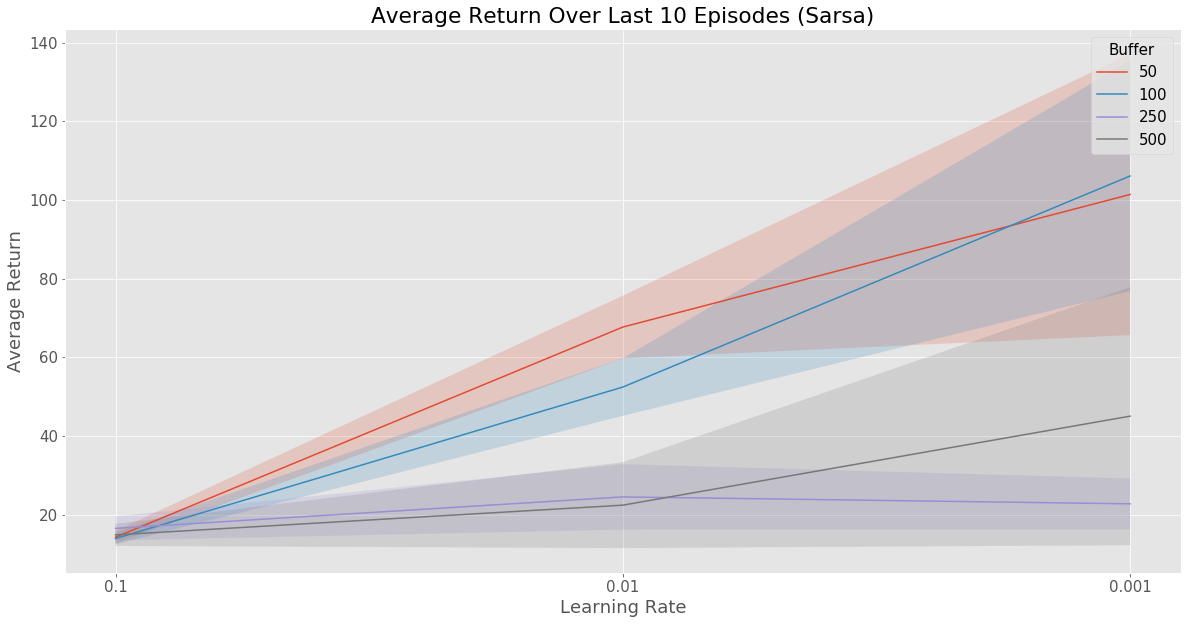

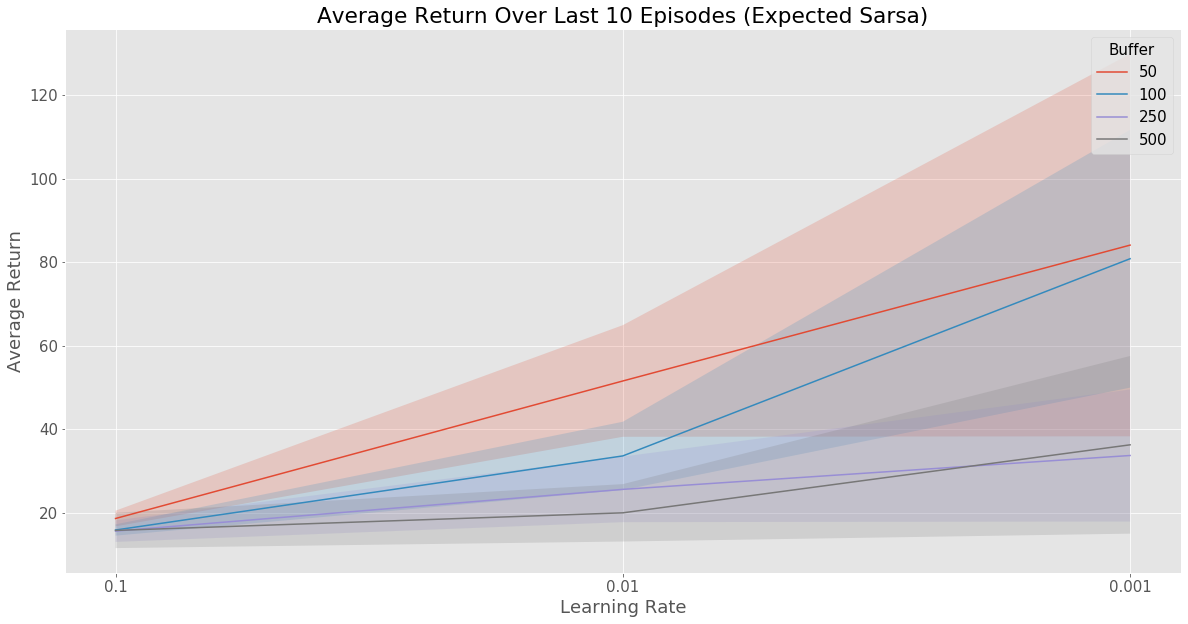

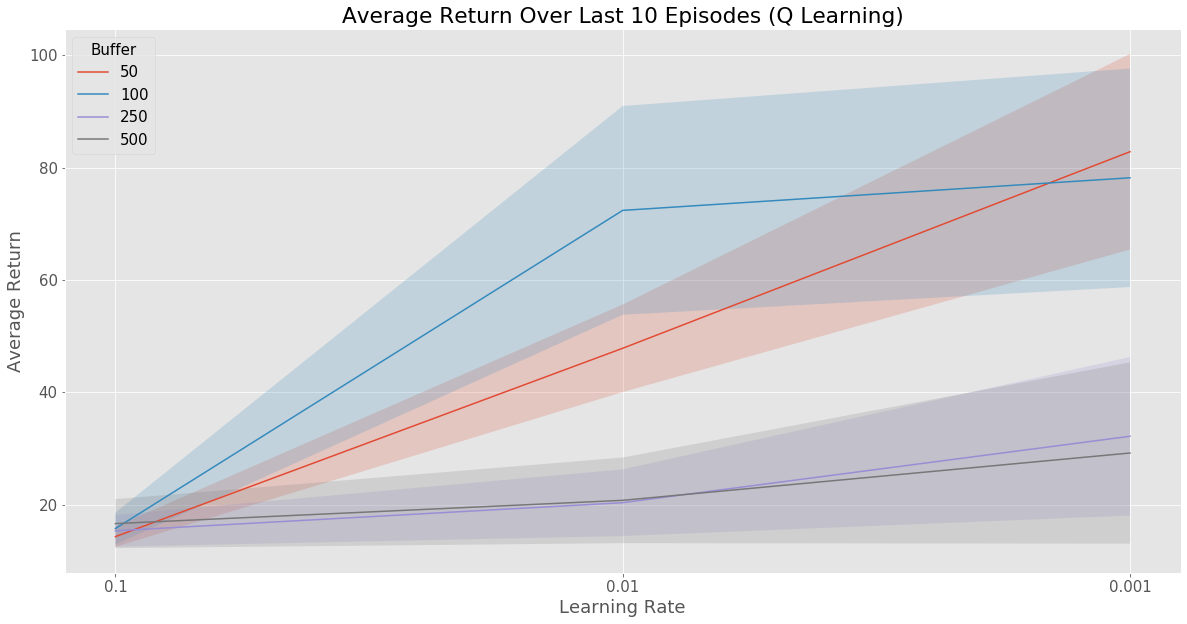

In [144]:
plot_dict = {}
df_arr = []

for method in methods[:]:
    if method not in plot_dict.keys():
        plot_dict[method] = {}
    
    plt.figure()
    for buffer in buffers:
        if buffer not in plot_dict[method].keys():
            plot_dict[method][buffer] = {}
        means = []
        stds = []
        for lr in learning_rates:
            if lr not in plot_dict[method][buffer].keys():
                plot_dict[method][buffer][lr] = {}
            steps = []
            for seed in seeds:
                steps.append(results_dict[method][buffer][lr][seed])
                
            seeds_np = np.array(steps)
            seeds_np_10 = seeds_np[:,-10:]
            seeds_np_10_mean = np.mean(seeds_np_10, axis=1)
            seeds_np_10_mean_mean = np.mean(seeds_np_10_mean)
            seeds_np_10_mean_std = np.std(seeds_np_10_mean)
            # 90% conf interval
            seeds_np_10_mean_confint = 1.282 * seeds_np_10_mean_std / np.sqrt(len(seeds))
            
            
            means.append(seeds_np_10_mean_mean)
#             stds.append(seeds_np_10_mean_std)
            stds.append(seeds_np_10_mean_confint)

        min_stds = []
        max_stds = []
        
        for i in range(len(means)):
            min_stds.append(means[i] - stds[i])
            max_stds.append(means[i] + stds[i]) 
        
        plt.plot(means, label=buffer)
        plt.fill_between(range(len(min_stds)), min_stds, max_stds, alpha='0.2')
        plt.legend(title="Buffer")
        plt.xticks(np.arange(len(learning_rates)), learning_rates)
        plt.title("Average Return Over Last 10 Episodes ({method})".format(method=name_lookup[method]))
        plt.xlabel("Learning Rate")
        plt.ylabel("Average Return")


        
            
            
            

Please note that due to long times it took for the overall computation, there were limitations in the combinations of hyperparameters that were tried (approved by Veronica upon asking). Ideally, more learning rates would be tried, in the range of 1, 0.5, 0.1, 0.05, 0.01, 0.001 and 0.0001. However, 0.1, 0.01 and 0.001 were used. More episodes would also be tried give more time and computing resources as the episodes were limited to 100. Instead of using 20 different seeds, 5 seeds were used for each experiment. Even with the limitations, the overall training time was over 15 hours.

Sarsa performed the best with Expected Sarsa having the second best results and Q Learning performing the worst. Q Learning, which is off-policy, was expected to have the worst returns. Sarsa, being on-policy, was expected to have better returns. Expected Sarsa, which takes the expected values of the states, would in theory have the best returns, but could require more episodes. The 100 episode computation limit could be a reason why Sarsa performed better compared to Expected Sarsa. If more episodes were run, Expected Sarsa would have the best returns. It must be noted that the standard deviation confidence intervals vary quite a lot. This can be remedied with more episodes as one can expect the variance to decrease with more training. More runs/seeds would also be ideal to gain more confidence on the standard deviations.

All three methods performed best with buffers of 50 and 100 for the experience replay. This is fairly common when training neural nets as lower batch sizes usually results in better accuracy. The returns also increased as the learning rates were decreased. It would be interesting to test how higher and lower learning rates affect the returns, but as mentioned previously, this was limited due to the computating constraints.

Overall, the results were aligned with expectations. The on-policy Sarsa method performed better than the off-policy Q Learning, with Expected Sarsa performing the second best and most likely the best with more training episodes. Improvements would be to allow for more training episodes for better convergence and to experiment with lowering the learning rates even more. 

The combination of parameters with the best returns are as follows: Sarsa with an experience replay buffer of 100 and a learning rate of 0.001.

#### second plot

In [139]:
# the best combination: sarsa, buffer of 100, learning rate of 0.001

In [145]:
best_means = []

for seed in results_dict['sarsa'][100][0.001].keys():
    best_means.append(results_dict['sarsa'][100][0.001][seed])

best_means = np.array(best_means)
best_means = np.mean(best_means, axis=0)
best_stds = np.std(best_means, axis=0)
# 90th percentile conf interval
best_stds_confint = 1.282 * best_stds / np.sqrt(len(results_dict['sarsa'][100][0.001]))
best_min_stds = best_means - best_stds_confint
best_max_stds = best_means + best_stds_confint

Text(0, 0.5, 'Average Return')

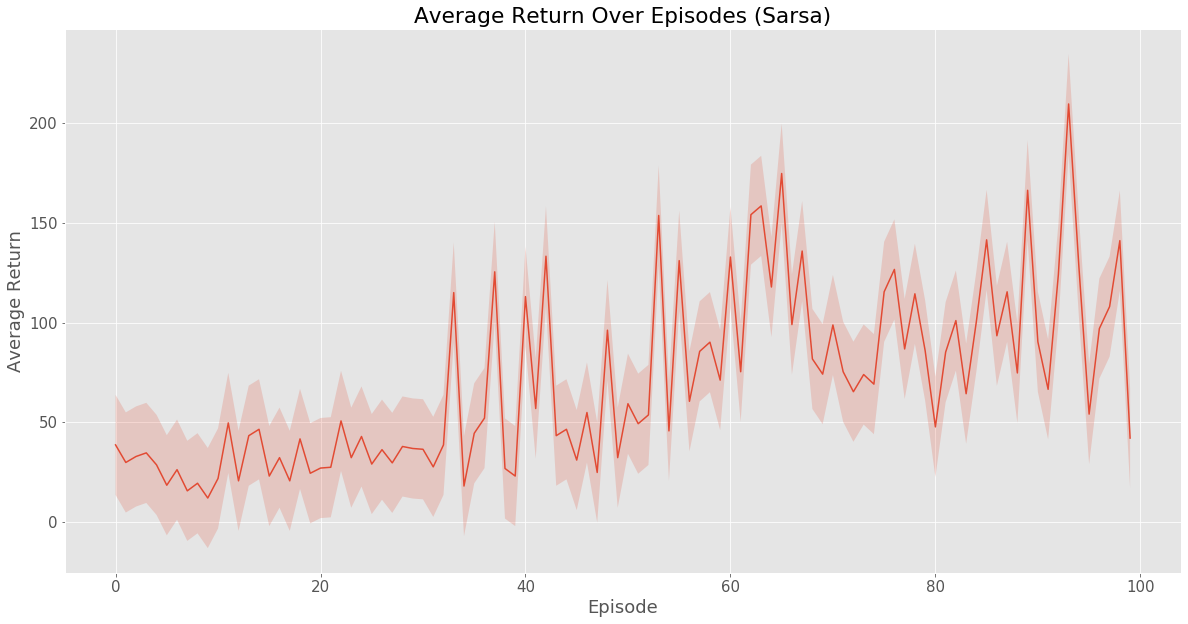

In [146]:
plt.plot(best_means)
plt.fill_between(range(len(best_min_stds)), best_min_stds, best_max_stds, alpha='0.2')
plt.title("Average Return Over Episodes (Sarsa)")
plt.xlabel("Episode")
plt.ylabel("Average Return")